# ESSC4510/EASC5510 Statistical and Data Analysis for Earth System Science

## Chapter 9 Detecting correlations among data

The following are the sample codes for the tutorial in the lecture and the book *Environmental Data Analysis with MATLAB*.

**ALL COPYRIGHT RESERVED**



In [1]:
# eda09_00 clear all variables and import vatious modules
%reset -f
import os
from datetime import date
from math import exp, pi, sin, cos, tan, sqrt, floor, ceil, log
import numpy as np
import scipy.sparse.linalg as las
from scipy import sparse
import scipy.linalg as la
import scipy.signal as sg
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

# eda_draw function makes a "pictorial matrix equation"
# arguments are vectors, matrices and strings
# which are plotted in the order that the appear
# except that strings starting with 'title ' are plotted
# under the subseqeunt matrix or vector
# always returns a status of 1

def eda_draw(*argv):
    bw = np.zeros((256,4));
    v = 0.9*(256 - np.linspace( 0, 255, 256 ))/255;
    bw[:,0] = v;
    bw[:,1] = v;
    bw[:,2] = v;
    bw[:,3] = np.ones(256);
    bwcmap = ListedColormap(bw);
    # size of plot
    W = 16;
    H = 4;
    fig1 = plt.figure(1);
    # figsize width and height in inches
    fig1.set_size_inches(W,H);
    ax1 = plt.subplot(1,1,1);
    plt.axis([0, W, -H/2, H/2]);
    plt.axis('off');
    LM = W/6;    # matrix width and heoght
    LV = W/40;   # vector width
    FS = 0.12;    # character width
    TO = 0.4;    # title vertical offset
    SP = 0.2;    # space between objects
    LS = 0.2;    # leading space
    p = LS; # starting x-position
    istitle=0; # flags presence of a title
    for a in argv:
        if isinstance(a,np.ndarray):
            sh = np.shape(a);
            if len(sh) == 1:  # conversion to nx1 array
                n = sh[0];
                m = 1;
                ap = a;
                a = np.zeros((n,1));
                a[:,0] = ap;
            else:
                n = sh[0];
                m = sh[1];
            if m==1:
                pold=p;
                left=p;
                right=p+LV;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LV;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
            else:
                pold=p;
                left=p;
                right=p+LM;
                bottom=-LM/2;
                top=LM/2;
                plt.imshow( a, cmap=bwcmap, vmin=np.min(a), vmax=np.max(a), extent=(left,right,bottom,top) );
                p = p+LM;
                pm = (p+pold)/2;
                if istitle:
                    plt.text(pm,-(LM/2)-TO,titlestr,horizontalalignment='center');
                    istitle=0;
                p = p+SP;
        elif isinstance(a,str):
            ns = len(a);
            istitle=0;
            if( ns>=6 ):
                if 'title ' in a[0:6]:
                    istitle=1;
                    titlestr=a[6:];
            if( istitle != 1):
                plt.text(p,0,a);
                p = p + ns*FS + SP;
    plt.show();
    return 1;


def FTFmul(v):
    # this function is used by the bicongugate gradient solver to solve the geneneralized least
    # squares problem Fm=f.  Note that "F" must be called "edaFsparse".
    global edaFsparse;
    s = np.shape(v);
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    temp = edaFsparse*vv;
    return edaFsparse.transpose()*temp;


def GLSFilterMul(v):
    # this function is used by the bicongugate gradient solver to solve the
    # geneneralized least squares problem Fm=f with F=[G;H] and f=[d,h],
    # where G is a topplitz matrix built from the filter g
    # Note that "H" must be sparese and called "edaHsparse" and that
    # the filter "g" bust be called edafilterg and must be a column vector
    global edaHsparse;
    global edafilterg;
    # rearrange as column-vector
    s = np.shape(v);
    M = s[0];
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    N, i = np.shape(edafilterg);
    # implements (GT G + HT H) v
    temp1 = np.zeros((N+M-1,1));
    temp1[:,0] = np.convolve(edafilterg.ravel(),vv.ravel()); # G v is of length N
    a = np.zeros((N,1));
    a[:,0] = temp1[0:N,0];
    b = edaHsparse * v; # H v is of length K
    temp2 = np.zeros((N+N-1,1));
    temp2[:,0] = np.convolve((np.flipud(edafilterg)).ravel(),a.ravel()); # GT (G v) is of length M
    a2 = temp2[N-1:N+M-1,0];
    b2 = edaHsparse.transpose()*b; # HT (H v) is of length M
    # FT F v = GT G v + HT H v
    return (a2+b2);


def GLSautoMul(v):
    # this function is used by the bicongugate gradient solver to solve the
    # geneneralized least squares problem Fm=f with F=[G;H] and f=[d,h],
    # where GTG is built from the autocorrelation of the filter g
    global edaHsparse;
    global edaautoc;
    # rearrange as column-vector
    s = np.shape(v);
    M = s[0];
    if(len(s)==1):
        vv = np.zeros((s[0],1));
        vv[:,0] = v;
    else:
        vv=v;
    # FT F v = GT G v + HT H v
    GTGv=np.zeros((M,1));
    for i in range(M):
        u = np.concatenate( (np.flipud(edaautoc[0:i+1,0]), edaautoc[1:M-i,0]), axis=0 );
        GTGv[i,0] =  np.matmul( u.T, vv );
    Hv = edaHsparse*vv;
    HTHv = edaHsparse.transpose()*Hv;
    return (GTGv + HTHv);


def chebyshevfilt(d, Dt, flow, fhigh):
    #chebyshevfilt
    # chebyshev IIR bandpass filter
    # d - input array of data
    # Dt - sampling interval
    # flow - low pass frequency, Hz
    # fhigh - high pass frequency, Hz
    # dout - output array of data
    # u - the numerator filter
    # v - the denominator filter
    # these filters can be used again using dout=filter(u,v,din);

    # make sure input timeseries is a column vector
    s = np.shape(d);
    N = s[0];
    if(N==1):
        dd = np.zeros((N,1));
        dd[:,0] = d;
    else:
        dd=d;
        
    # sampling rate
    rate=1/Dt;

    # ripple parameter, set to ten percent
    ripple=0.1;  

    # normalise frequency
    fl=2.0*flow/rate;
    fh=2.0*fhigh/rate;

    # center frequency 
    cf = 4 * tan( (fl*pi/2) ) * tan( (fh*pi/2) );

    # bandwidth
    bw = 2 * ( tan( (fh*pi/2) ) - tan( (fl*pi/2) ) );

    # ripple parameter factor
    rpf = sqrt((sqrt((1.0+1.0/(ripple*ripple))) + 1.0/ripple));
    a = 0.5*(rpf-1.0/rpf);
    b = 0.5*(rpf+1.0/rpf);

    u=np.zeros((5,1));
    v=np.zeros((5,1));
    theta = 3*pi/4;
    sr = a * cos(theta);
    si = b * sin(theta);
    es = sqrt(sr*sr+si*si);
    tmp= 16.0 - 16.0*bw*sr + 8.0*cf + 4.0*es*es*bw*bw - 4.0*bw*cf*sr + cf*cf;
    v[0,0] = 1.0;
    v[1,0] = 4.0*(-16.0 + 8.0*bw*sr - 2.0*bw*cf*sr + cf*cf)/tmp;
    v[2,0] = (96.0 - 16.0*cf - 8.0*es*es*bw*bw + 6.0*cf*cf)/tmp;
    v[3,0] = (-64.0 - 32.0*bw*sr + 8.0*bw*cf*sr + 4.0*cf*cf)/tmp;
    v[4,0] = (16.0 + 16.0*bw*sr + 8.0*cf + 4.0*es*es*bw*bw + 4.0*bw*cf*sr + cf*cf)/tmp;
    tmp = 4.0*es*es*bw*bw/tmp;
    u[0,0] = tmp;
    u[1,0] = 0.0;
    u[2,0] = -2.0*tmp;
    u[3,0] = 0.0;
    u[4,0] = tmp;

    dout = sg.lfilter(u.ravel(),v.ravel(),dd.ravel());
    return (dout,u,v);



correlation coefficients:


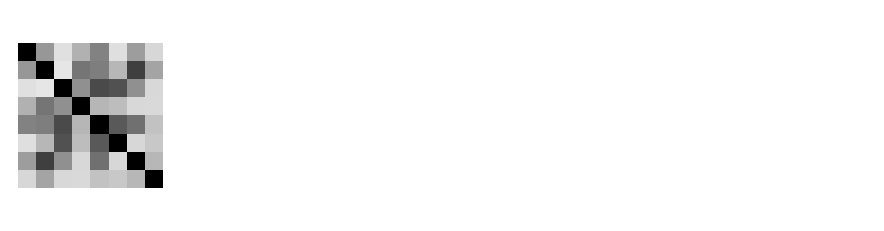

mean and standard deviations:
    SiO2: 50.388700 7.209022
    TiO2: 1.364637 1.208305
    Al203: 15.255543 3.949684
    FeO: 9.860720 3.112876
    MgO: 7.876269 2.853069
    CaO: 11.641090 3.511410
    Na2O: 2.471665 1.469694
    K2O: 0.190218 0.387298
 
covariance and correlation coefficient:
    SiO2 vs TiO2: 0.176776 0.361535
    SiO2 vs Al203: 0.103385 0.049821
    SiO2 vs FeO: 0.427913 0.249633
    SiO2 vs MgO: -1.869543 -0.449582
    SiO2 vs CaO: 0.098530 0.057043
    SiO2 vs Na2O: 0.203303 0.334273
    SiO2 vs K2O: 0.021383 0.088796
    TiO2 vs Al203: 0.013893 0.022992
    TiO2 vs FeO: 0.251822 0.504489
    TiO2 vs MgO: -0.568284 -0.469300
    TiO2 vs CaO: -0.112748 -0.224158
    TiO2 vs Na2O: 0.129429 0.730804
    TiO2 vs K2O: 0.021179 0.302024
    Al203 vs FeO: -0.819501 -0.386845
    Al203 vs MgO: -3.517052 -0.684375
    Al203 vs CaO: 1.407959 0.659577
    Al203 vs Na2O: 0.291717 0.388115
    Al203 vs K2O: 0.024097 0.080970
    FeO vs MgO: -0.959504 -0.226022
    FeO vs CaO:

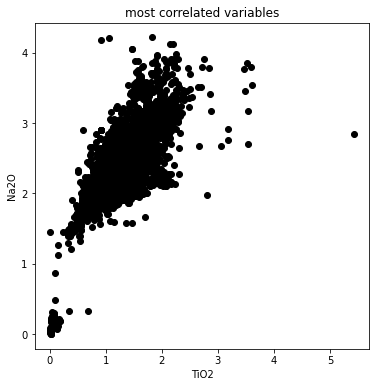

In [3]:
# eda09_01
# estimate covariance and etc of rorck data types

D = np.genfromtxt('rocks.txt', delimiter='\t')
[N, M]=D.shape;
# 0: SiO2
# 1: TiO2
# 2: Al203
# 3: FeO-total
# 4: MgO
# 5: CaO
# 6: Na2O
# 7: K2O

# note use of a tupple to create array of variable names
name = ( 'SiO2', 'TiO2', 'Al203', 'FeO', 'MgO', 'CaO', 'Na2O', 'K2O' );

dbar = np.zeros((M,1));
dbar[:,0] = np.mean(D,axis=0); # mean
C = np.cov(D,rowvar=False); # covariance
sigma = np.zeros((M,1));
sigma[:,0] = np.sqrt(np.diag(D)).ravel(); # stddev
R = np.corrcoef(D,rowvar=False); # correlation coefficient

# plot correlation coefficent matrix
print('correlation coefficients:')
eda_draw(np.abs(R));

# display results; also find most correlated data
print('mean and standard deviations:')
for i in range(M):
    print( "    %s: %f %f" % (name[i], dbar[i,0], sigma[i,0]) );

print(' ');
icor=1;
jcor=2;
r=0;
print('covariance and correlation coefficient:')
for i in range(M):
    for j in range(i+1,M):
        print( "    %s vs %s: %f %f" % (name[i], name[j], C[i,j], R[i,j])) ;
        if( abs(R[i,j]) > r ):
            r = abs(R[i,j]);
            icor=i;
            jcor=j;
        
fig2 = plt.figure(2,figsize=(6,6));
ax1 = plt.subplot(1,1,1);
plt.plot(D[:,icor],D[:,jcor],'ko');
plt.xlabel(name[icor]);
plt.ylabel(name[jcor]);
plt.title('most correlated variables');
plt.show();


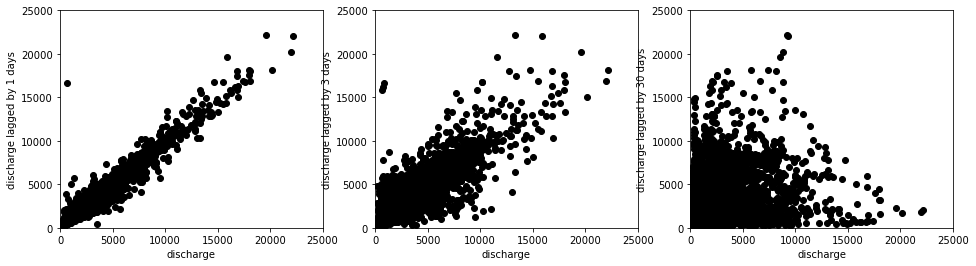

In [4]:
# eda09_02
# load the neuse.txt data set
# make scatter plots of lagged samples
# in order to investigate correlation

D = np.genfromtxt('neuse.txt', delimiter='\t')
[N, M]=D.shape;

t = np.zeros((N,1));
t[:,0] = D[:,0];
d = np.zeros((N,1));
d[:,0] = D[:,1];

fig1 = plt.figure(1,figsize=(16,4));

lag=1;
ax1 = plt.subplot(1,3,1);
plt.axis([0, 25000, 0, 25000]);
plt.plot(d[0:N-lag,0], d[lag:N,0],'ko');
plt.xlabel('discharge');
plt.ylabel("discharge lagged by %d days" % (lag) );


lag=3;
ax2 = plt.subplot(1,3,2);
plt.axis([0, 25000, 0, 25000]);
plt.plot(d[0:N-lag,0], d[lag:N,0],'ko');
plt.xlabel('discharge');
plt.ylabel("discharge lagged by %d days" % (lag) );

lag=30;
ax3 = plt.subplot(1,3,3);
plt.axis([0, 25000, 0, 25000]);
plt.plot(d[0:N-lag,0], d[lag:N,0],'ko');
plt.xlabel('discharge');
plt.ylabel("discharge lagged by %d days" % (lag) );

plt.show();

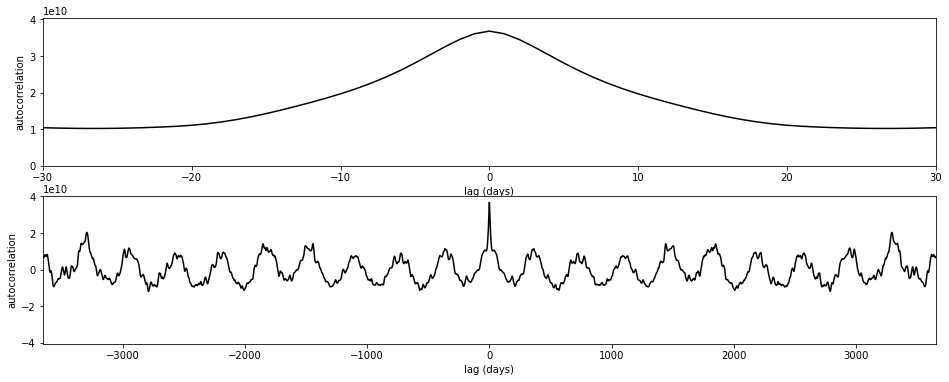

In [5]:
# eda09_03
# load the neuse.txt data set
# compute and plot autocorrelation

D = np.genfromtxt('neuse.txt', delimiter='\t')
[N, M]=D.shape;
t = np.zeros((N,1));
t[:,0] = D[:,0];
d = np.zeros((N,1));
d[:,0] = D[:,1];
Dt=t[1,0]-t[0,0];

# demean the data
d=d-np.mean(d);

# compute the autocorrelation
a = np.correlate(d.ravel(), d.ravel(), mode='full');

# time asxis for autocorrelation
tau = np.zeros((2*N-1,1));
tau[:,0] = np.linspace(-N+1,N-1,2*N-1);

# number pf points correlated for each lag
Nk = np.concatenate( ( np.linspace(1,N,N), np.linspace(N-1,1,N-1) ) );

# correction for length of timeseries
a = N*np.divide( a, Nk );

fig1 = plt.figure(1,figsize=(16,6));

lag=1;
ax1 = plt.subplot(2,1,1);
plt.axis([ -30, 30, 0, 1.1*np.max(a) ]);
plt.plot( tau, a, 'k-');
plt.xlabel('lag (days)');
plt.ylabel('autocorrelation');

ax2 = plt.subplot(2,1,2);
plt.axis([ -365.25*10, 365.25*10, -1.1*np.max(a), 1.1*np.max(a) ]);
plt.plot( tau, a,'k-');
plt.xlabel('lag (days)');
plt.ylabel('autocorrelation');

plt.show();


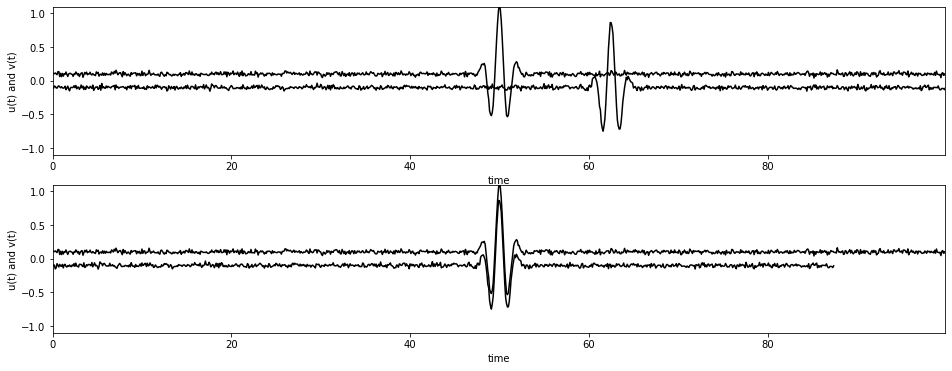

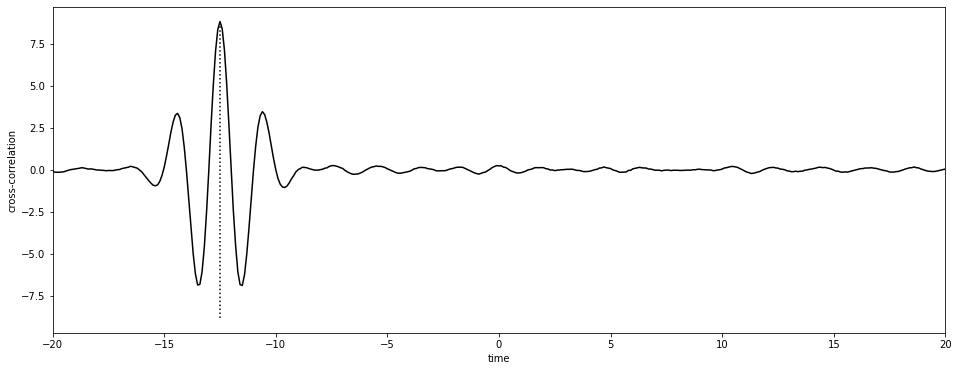

lag: true: 12.50 estimated: 12.50


In [6]:
# eda09_04
# using the cross correlation to align two timeseries
# this example uses synthetic data

# time series paramaters
N=1000;
Dt=0.1;
t = np.zeros((N,1));
t[:,0] = Dt*np.linspace(0,N-1,N);

# synthetic time series, u and v
t1 = Dt*4*N/8;
t2 = Dt*5*N/8;
tlagtrue = t2-t1;
w0 = 2*pi*0.5;
u = np.zeros((N,1));
v = np.zeros((N,1));
u[:,0] = (np.multiply( np.cos( w0 * (t-t1) ), np.exp( -np.power((t-t1),2)/2 )) + np.random.normal(0.0,0.02,(N,1))).ravel();
v[:,0] = (np.multiply( np.cos( w0 * (t-t2) ), np.exp( -np.power((t-t2),2)/2 )) + np.random.normal(0.0,0.02,(N,1))).ravel();

fig1 = plt.figure(1,figsize=(16,6));
ax1 = plt.subplot(2,1,1);
plt.axis([t[0,0], t[N-1,0], -1.1, 1.1]);
plt.plot( t, u+0.1, 'k-');
plt.plot( t, v-0.1, 'k-');
plt.xlabel('time');
plt.ylabel('u(t) and v(t)');

# cross correlation
Nc = 2*N-1;
c = np.zeros((Nc,1));
c[:,0] = np.correlate(u.ravel(), v.ravel(), mode='full');

# time asxis for autocorrelation
tau = np.zeros((2*N-1,1));
tau[:,0] = Dt*np.linspace(-N+1,N-1,2*N-1);

# find best lag
Ncenter = (Nc+1)/2;
cmax = np.max(c);
icmax = np.argmax(c);
tlag = -Dt * (icmax-N+1);

# plot lagged timeseries
ax2 = plt.subplot(2,1,2);
plt.axis([t[0,0], t[N-1,0], -1.1, 1.1]);
plt.plot( t, u+0.1, 'k-');
plt.plot( t-tlag, v-0.1, 'k-');
plt.xlabel('time');
plt.ylabel('u(t) and v(t)');

#  plot cross-correlation
fig2 = plt.figure(2,figsize=(16,6));
ax2 = plt.subplot(1,1,1);
plt.axis( [-20, 20, -1.1*cmax, 1.1*cmax] );
plt.plot( tau, c, 'k-');
plt.plot( [-tlag, -tlag], [-cmax, cmax], 'k:');
plt.xlabel('time')
plt.ylabel('cross-correlation');
plt.show();

print( "lag: true: %.2f estimated: %.2f" % (tlagtrue, tlag) );

unlagged data


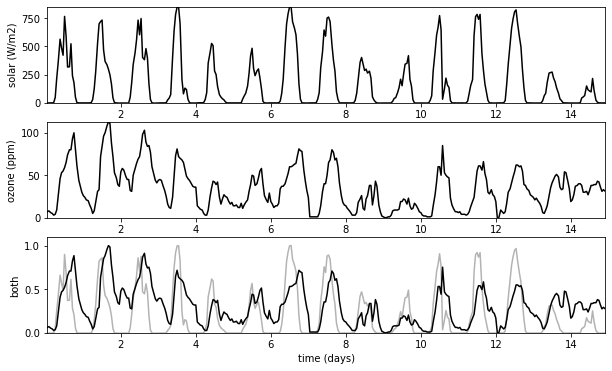

lagged data


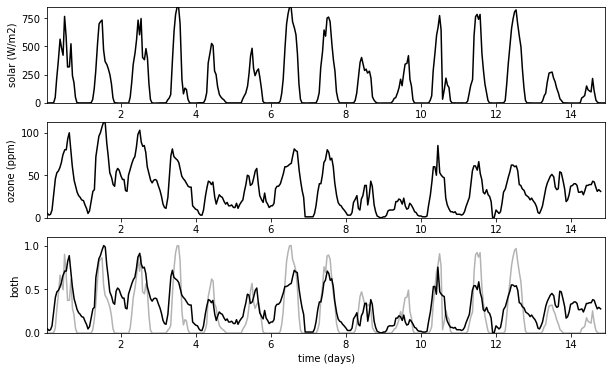

lagged data, zoomed


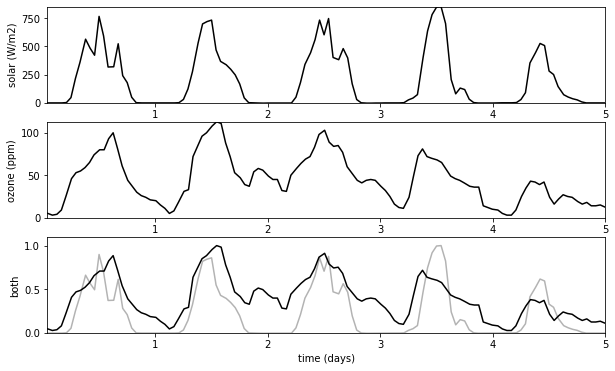

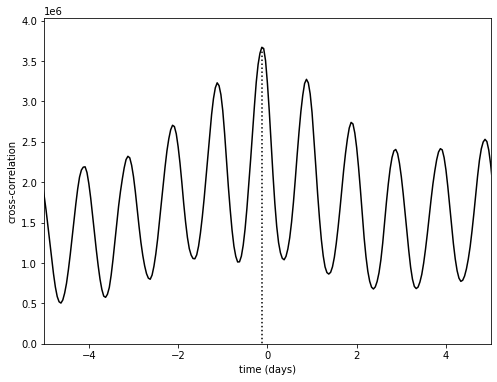

estimated lag: 3.00 hours


In [7]:
# eda09_05
# using the cross correlation to align two timeseries
# West Point ozone data

D = np.genfromtxt('ozone_nohead.txt', delimiter='\t')
[N, M]=D.shape;
t = np.zeros((N,1));
t[:,0] = D[:,0];         # time in days after 1:00 AM on Aug 1, 1993
Dt=1/24;
tmin = t[0,0];
tmax = t[N-1,0];
ozone = np.zeros((N,1));
ozone[:,0] = D[:,1];     # ozone in ppm
radiation = np.zeros((N,1));
radiation[:,0] = D[:,2]; # solar radiation in W/m2
temp = np.zeros((N,1));
temp[:,0] = D[:,3];      # temperature in deg C

# plot original timeseries
print('unlagged data');
fig1 = plt.figure(1,figsize=(10,6));

# solar radiation
ax1 = plt.subplot(3,1,1);
plt.axis([tmin, tmax, 0, np.max(radiation)]);
plt.plot( t, radiation, 'k-');
plt.xlabel('time (days)');
plt.ylabel('solar (W/m2)');

# ozone
ax2 = plt.subplot(3,1,2);
plt.axis([tmin, tmax, 0, np.max(ozone)]);
plt.plot( t, ozone, 'k-');
plt.xlabel('time (days)');
plt.ylabel('ozone (ppm)');

# both
ax3 = plt.subplot(3,1,3);
plt.axis([tmin, tmax, 0, 1.1]);
plt.plot( t, radiation/np.max(radiation), 'k-', color=(0.7,0.7,0.7));
plt.plot( t, ozone/np.max(ozone), 'k-');
plt.xlabel('time (days)');
plt.ylabel('both');

plt.show();

# cross correlation
Nc = 2*N-1;
c = np.zeros((Nc,1));
c[:,0] = np.correlate(radiation.ravel(), ozone.ravel(), mode='full');

# time asxis for autocorrelation
tau = np.zeros((2*N-1,1));
tau[:,0] = Dt*np.linspace(-N+1,N-1,2*N-1);

# find best lag
Ncenter = (Nc+1)/2;
cmax = np.max(c);
icmax = np.argmax(c);
tlag = -Dt * (icmax-N+1);

# unlagged plot
print('lagged data');
fig2 = plt.figure(2,figsize=(10,6));

# solar radiation
ax1 = plt.subplot(3,1,1);
plt.axis([tmin, tmax, 0, np.max(radiation)]);
plt.plot( t, radiation, 'k-');
plt.xlabel('time (days)');
plt.ylabel('solar (W/m2)');

# ozone
ax2 = plt.subplot(3,1,2);
plt.axis([tmin, tmax, 0, np.max(ozone)]);
plt.plot( t-tlag, ozone, 'k-');
plt.xlabel('time (days)');
plt.ylabel('ozone (ppm)');

# both
ax3 = plt.subplot(3,1,3);
plt.axis([tmin, tmax, 0, 1.1]);
plt.plot( t, radiation/np.max(radiation), 'k-', color=(0.7,0.7,0.7));
plt.plot( t-tlag, ozone/np.max(ozone), 'k-');
plt.xlabel('time (days)');
plt.ylabel('both');

plt.show();


# lagged plot, zommed
days=5;
print('lagged data, zoomed');
fig2 = plt.figure(2,figsize=(10,6));

# solar radiation
ax1 = plt.subplot(3,1,1);
plt.axis([t[0,0], t[days*24-1,0], 0, np.max(radiation)]);
plt.plot( t, radiation, 'k-');
plt.xlabel('time (days)');
plt.ylabel('solar (W/m2)');

# ozone
ax2 = plt.subplot(3,1,2);
plt.axis([t[0,0], t[days*24-1,0], 0, np.max(ozone)]);
plt.plot( t-tlag, ozone, 'k-');
plt.xlabel('time (days)');
plt.ylabel('ozone (ppm)');

# both
ax3 = plt.subplot(3,1,3);
plt.axis([t[0,0], t[days*24-1,0], 0, 1.1]);
plt.plot( t, radiation/np.max(radiation), 'k-', color=(0.7,0.7,0.7));
plt.plot( t-tlag, ozone/np.max(ozone), 'k-');
plt.xlabel('time (days)');
plt.ylabel('both');

plt.show();

plt.show();

#plot cross-correlation
fig3 = plt.figure(3,figsize=(8,6));
ax2 = plt.subplot(1,1,1);
plt.axis( [-5, 5, 0, 1.1*cmax] );
plt.plot( tau, c, 'k-');
plt.plot( [-tlag, -tlag], [-cmax, cmax], 'k:');
plt.xlabel('time (days)')
plt.ylabel('cross-correlation');
plt.show();

print( "estimated lag: %.2f hours" % (24*tlag) );


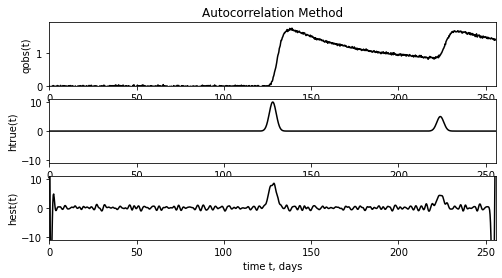

In [8]:
# eda09_06
# example of a filter problem
# using impulse repsonse of a heat-producing layer
# with solution via generalized least squares
# using bicongugate gradient method
# with the prior information of smoothness
# Note: symbol q for theta, temperture

# time setup for g (length M)
M=1024;
N=M;
Dtdays = 0.5;
tdays = np.zeros((N,1));
tdays[:,0] = Dtdays*np.linspace(0,Dtdays*(N-1),N);
Dtseconds = Dtdays*3600*24;
tseconds = Dtseconds*tdays;

# materal constants
rho = 1500; # kg/m3
cp = 800; # J / kg-K
kappa = 1.25e-6; # m2/s
z = 1; # m

# impulse response
g = np.zeros((M,1));
g[0,0] = 0.0;
P1 = (1/(rho*cp));
P2 = (Dtseconds/sqrt(2*pi));
P3 = np.reciprocal( np.sqrt(2*kappa*tseconds[1:M]));
P4 = np.exp( -0.5*(z**2)*np.reciprocal(2*kappa*tseconds[1:M]));
g[1:M,0] = (P1 * P2 * np.multiply(P3 ,P4)).ravel();
edafilterg = g;

# true heat production
t1 = Dtdays*N/4;
t2 = Dtdays*7*N/16;
sd = Dtdays*N/256;
Ah=10;
P5 = np.exp(-np.power(tdays-t1,2) / (2*sd**2) );
P6 = np.exp(-np.power(tdays-t2,2) / (2*sd**2) );
htrue = np.zeros((N,1));          
htrue[:,0] = (Ah*P5 + 0.5*Ah*P6).ravel();

# predict true temperature 
qtrue = np.zeros((N,1));
tmp = np.convolve(g.ravel(), htrue.ravel())
qtrue[0:N,0]=tmp[0:N];

# create simulated observations, qobs = qtrue+noise
sigmad=0.01*np.amax(qtrue);
qobs=qtrue+np.random.normal(0,sigmad,(N,1));

# solve for h given qobs and g using generalized least squares
# with a prior smoothness constraint using biconjugate gradient

# autocorrelation, a, of g. Just keep positive values
# it needs to be of at least length M, since g is of
# length N, and ordinarily N>=M.
tmp = np.correlate(g.ravel(),g.ravel(),mode='full');
edaautoc = np.zeros((M,1));
edaautoc[:,0] = tmp[M-1:2*M-1];

# cross-correlation, c, of qobs2 and g. Just keep positive values
# also, it needs to be of length M
tmp = np.correlate(qobs.ravel(), g.ravel(),mode='full');
Ntmp = len(tmp)
Ntmp2 = floor(Ntmp/2);
Nc = Ntmp-Ntmp2;
tmp2 = np.zeros((Nc,1));
tmp2[:,0] = tmp[Ntmp2: Ntmp];
c = np.zeros((M,1));
c[0:M,0] = tmp2[0:M,0];

# set up H and h and f
e=1*np.amax(g);
edaHsparse = sparse.diags([e, -2*e, e], [0, 1, 2], shape=(M-2, M));
h = np.zeros((M-2,1));

# set up F'f = GT qobs + HT h
# GT qobs is c=qobs2*g
HTh =  edaHsparse.transpose() * h;
FTf = c + HTh;

# define linear operator needed for conjugate gradienet solver
LO=las.LinearOperator(shape=(M,M),matvec=GLSautoMul,rmatvec=GLSautoMul);

# solve for estimated model parameters using congugate gradient algrorithm
hest3 = np.zeros((M,1));
q=las.cg(LO,FTf,tol=1e-6, maxiter=(3*(N+M)+100));
hest3[:,0] = q[0];

# figure 1
fig1 = plt.figure(1,figsize=(8,4));

# plot observations
ax1 = plt.subplot(3,1,1);
plt.axis([tdays[0,0], tdays[N-1,0], 0, 1.1*np.max(qobs)] );
plt.plot(tdays[0:N],qobs,'k-');
plt.xlabel('time t, days');
plt.ylabel('qobs(t)');
plt.title('Autocorrelation Method');

# plot true heat production
ax1 = plt.subplot(3,1,2);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],htrue,'k-');
plt.xlabel('time t, days');
plt.ylabel('htrue(t)');

# plot estimated heat production
ax1 = plt.subplot(3,1,3);
plt.axis([tdays[0,0], tdays[N-1,0], -1.1*np.max(htrue), 1.1*np.max(htrue)] );
plt.plot(tdays[0:N],hest3,'k-');
plt.xlabel('time t, days');
plt.ylabel('hest(t)');
plt.show();


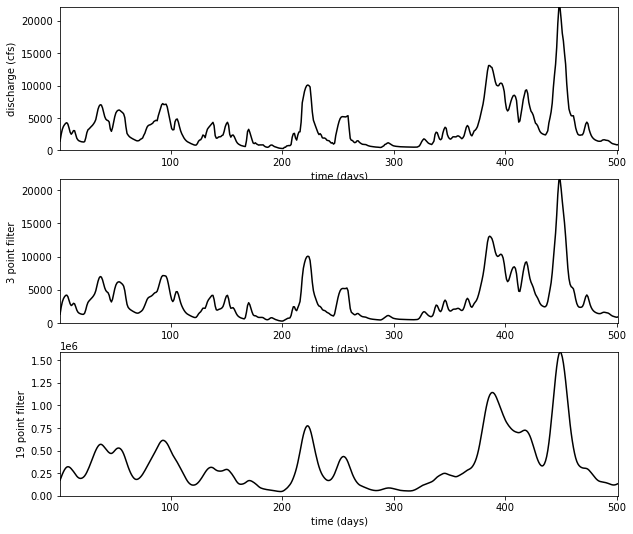

In [9]:
# eda09_07
# smooth neuse.txt

# load data
D = np.genfromtxt('neuse.txt', delimiter='\t')
[N, M]=D.shape;
t = np.zeros((N,1));
t[:,0] = D[:,0];         # time in days after 1:00 AM on Aug 1, 1993
Dt=t[1,0]-t[0,0];
tmin = t[0,0];
tmax = t[N-1,0];
d = np.zeros((N,1));
d[:,0] = D[:,1];         # discharge in cfs

# construct 3-point smoothing filter
L1 = 3;
s1 = np.zeros((L1,1));
s1[:,0] = [1, 2, 1];
s1 = s1/np.sum(s1);
Lh1 = floor(L1/2);

# filter and time shift
temp = np.convolve(s1.ravel(), d.ravel(), mode='full');
d1 = np.zeros((N,1));
d1[:,0] = temp[Lh1:N+Lh1];


# construct 19-point smoothing filter
L2 = 19;
s2 = np.zeros((L2,1));
s2[:,0] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1];
s2 = s2/np.sum(s1);
Lh2 = floor(L2/2);

# filter and time shift
temp = np.convolve(s2.ravel(), d.ravel(), mode='full');
d2 = np.zeros((N,1));
d2[:,0] = temp[Lh2:N+Lh2];

# plot only this time range (for clarity)
N1=0;
N2=500;

fig1 = plt.figure(1,figsize=(10,9));

# original
ax1 = plt.subplot(3,1,1);
plt.axis([t[N1,0], t[N2,0], 0, np.max(d)]);
plt.plot( t, d, 'k-');
plt.xlabel('time (days)');
plt.ylabel('discharge (cfs)');

# filtered
ax2 = plt.subplot(3,1,2);
plt.axis([t[N1,0], t[N2,0], 0, np.max(d1)]);
plt.plot( t, d1, 'k-');
plt.xlabel('time (days)');
plt.ylabel("%d point filter" % L1);

# filtered
ax3 = plt.subplot(3,1,3);
plt.axis([t[N1,0], t[N2,0], 0, np.max(d2)]);
plt.plot( t, d2, 'k-');
plt.xlabel('time (days)');
plt.ylabel("%d point filter" % L2);

plt.show();


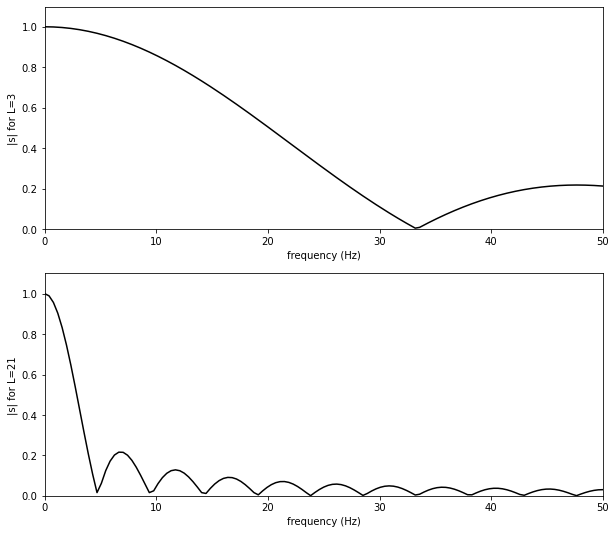

In [10]:
# eda09_08
# amplitude spectrum of uniform smoothing filter

# standard set up of time and frequency
N=256;
Dt=0.01;
No2 = floor(N/2);
tmin = 0;
tmax = Dt*(N-1);
t=np.zeros((N,1));
t[:,0]= np.linspace(tmin,tmax,N);
fmax=1/(2.0*Dt);
Df=fmax/No2;
Nf=No2+1;
f=np.zeros((N,1));
f[:,0] = Df * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Dw=2*pi*Df;
w=np.zeros((N,1));
w[:,0] = Dw * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Nw=Nf;
fpos=np.zeros((Nf,1));
fpos[:,0] = Df * np.linspace(0,No2,Nf);
wpos=np.zeros((Nf,1));
wpos[:,0] = Dw * np.linspace(0,No2,Nf);

# evaluate fourier transform of filter of length L
T1=3*Dt;
s1 = np.sinc(wpos*T1/(2*pi));
sa1 = np.abs(s1);

# evaluate fourier transform of filter of length L
T2=21*Dt;
s2 = np.sinc(wpos*T2/(2*pi));
sa2 = np.abs(s2);

# plot
fig1 = plt.figure(1,figsize=(10,9));

ax1 = plt.subplot(2,1,1);
plt.axis( [0,fmax, 0, 1.1]);
plt.plot( fpos, sa1, 'k-');
plt.xlabel('frequency (Hz)');
plt.ylabel('|s| for L=3');

ax2 = plt.subplot(2,1,2);
plt.axis( [0,fmax, 0, 1.1]);
plt.plot( fpos, sa2, 'k-');
plt.xlabel('frequency (Hz)');
plt.ylabel('|s| for L=21');

plt.show();


length 3 samples (0.030 seconds) sigma-t samples 3.742 (0.037 seconds)
length 21 samples (0.210 seconds) sigma-t samples 6.055 (0.061 seconds)


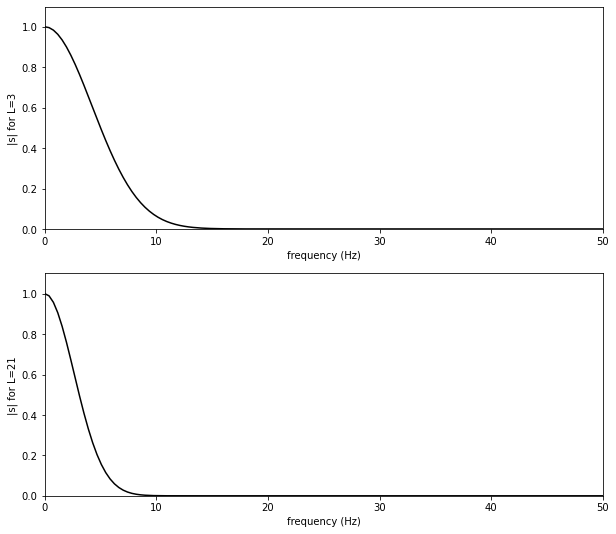

In [11]:
# eda09_09
# amplitude spectrum of Normal smoothing filter

# standard set up of time and frequency
N=256;
Dt=0.01;
No2 = floor(N/2);
tmin = 0;
tmax = Dt*(N-1);
t=np.zeros((N,1));
t[:,0]= np.linspace(tmin,tmax,N);
fmax=1/(2.0*Dt);
Df=fmax/No2;
Nf=No2+1;
f=np.zeros((N,1));
f[:,0] = Df * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Dw=2*pi*Df;
w=np.zeros((N,1));
w[:,0] = Dw * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Nw=Nf;
fpos=np.zeros((Nf,1));
fpos[:,0] = Df * np.linspace(0,No2,Nf);
wpos=np.zeros((Nf,1));
wpos[:,0] = Dw * np.linspace(0,No2,Nf);

# evaluate fourier transform of filter, g, of length L
L1=3;

# compute variance of filter (as if it were distribution)
g1 = np.ones((L1,1));
g1 = g1/np.sum(g1);
x = np.linspace(0,L1-1,L1);
mg1 = np.sum( np.multiply( x, g1 ) ) ;
vg1 = np.sum( np.multiply( np.power(x-mg1,2),  g1) );
sg1 = Dt*sqrt(vg1);

# fourier transform of gausian, using analytic formula
sigma1=1/sg1;
s1 = np.zeros((Nf,1));
s1[:,0] = np.exp(-np.power(wpos,2)/(2*(sigma1**2))).ravel();
sa1 = np.abs(s1);
print( "length %d samples (%.3f seconds) sigma-t samples %.3f (%.3f seconds)" % (L1, Dt*L1, sg1/Dt, sg1) );

# plot
fig1 = plt.figure(1,figsize=(10,9));

ax1 = plt.subplot(2,1,1);
plt.axis( [0,fmax, 0, 1.1]);
plt.plot( fpos, sa1, 'k-');
plt.xlabel('frequency (Hz)');
plt.ylabel('|s| for L=3');

# evaluate fourier transform of filter, g, of length L
L2=21;

# compute variance of filter (as if it were distribution)
g2 = np.ones((L2,1));
g2 = g1/np.sum(g2);
x = np.linspace(0,L2-1,L2);
mg2 = np.sum( np.multiply( x, g2 ) ) ;
vg2 = np.sum( np.multiply( np.power(x-mg2,2),  g2) );
sg2 = Dt*sqrt(vg2);

# fourier transform of gausian, using analytic formula
sigma2=1/sg2;
s2 = np.zeros((Nf,1));
s2[:,0] = np.exp(-np.power(wpos,2)/(2*(sigma2**2))).ravel();
sa2 = np.abs(s2);
print( "length %d samples (%.3f seconds) sigma-t samples %.3f (%.3f seconds)" % (L2, Dt*L2, sg2/Dt, sg2) );

ax2 = plt.subplot(2,1,2);
plt.axis( [0,fmax, 0, 1.1]);
plt.plot( fpos, sa2, 'k-');
plt.xlabel('frequency (Hz)');
plt.ylabel('|s| for L=21');

plt.show();

zero at 0.909


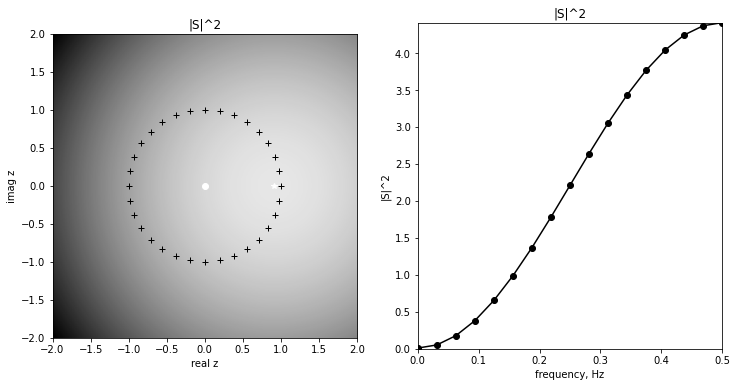

In [12]:
# eda09_10
# complex z-plane analysis of filters, case 1, highpass

# standard time/frequency setup
N=32;
Dt=1.0;
No2 = floor(N/2);
tmin = 0;
tmax = Dt*(N-1);
t=np.zeros((N,1));
t[:,0]= np.linspace(tmin,tmax,N);
fmax=1/(2.0*Dt);
Df=fmax/No2;
Nf=No2+1;
f=np.zeros((N,1));
f[:,0] = Df * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Dw=2*pi*Df;
w=np.zeros((N,1));
w[:,0] = Dw * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Nw=Nf;
fpos=np.zeros((Nf,1));
fpos[:,0] = Df * np.linspace(0,No2,Nf);
wpos=np.zeros((Nf,1));
wpos[:,0] = Dw * np.linspace(0,No2,Nf);

# a monomial filter, and its one root
F = np.zeros((2,1));
F[:,0] = [1, -1.1];
zp = -F[0,0]/F[1,0];  # 0=F1+F2*z  so z=-F1/F2
print("zero at %.3f" % (zp) );

# complex z-plane
Nz=128;
zmin=-2;
zmax=2;
dz=(zmax-zmin)/(Nz-1);
zr = np.zeros((Nz,1));
zi = np.zeros((Nz,1));
zr[:,0]=np.linspace(zmin,zmax,Nz);
zi[:,0]=np.linspace(zmin,zmax,Nz);

# evaluate filter polynomial everywhere in complex z-plane
S = np.zeros((Nz,Nz));
for n in range(Nz):
    for m in range(Nz):
        S[m,n] = abs( F[0,0] + F[1,0]*(zr[n,0]+complex(0,1)*zi[m,0]) )**2;

# plot amplitude of polynomial
fig1 = plt.figure(1,figsize=(12,6));

# black and white colormap
bw = np.zeros((256,4));
v = 0.9*(256 - np.linspace( 0, 255, 256 ))/255;
bw[:,0] = v;
bw[:,1] = v;
bw[:,2] = v;
bw[:,3] = np.ones(256);
bwcmap = ListedColormap(bw);

ax1 = plt.subplot(1,2,1);
plt.axis( [zmin,zmax,zmin,zmax]);

plt.imshow( S, cmap=bwcmap, vmin=np.min(S), vmax=np.max(S), extent=(zmin,zmax,zmin,zmax) );
plt.xlabel('real z');
plt.ylabel('imag z');
plt.title('|S|^2');

# plot Fourier transform points on the unit circle
plt.plot(0,0,'wo');
z=np.exp(-complex(0,1)*w*Dt);
plt.plot(np.real(z),np.imag(z),'k+');

# plot zero of filter
plt.plot(np.real(zp),np.imag(zp),'w*');

# plot frequency response of filter

Sz = np.abs( F[0,0]+F[1,0]*z )**2;

ax2 = plt.subplot(1,2,2);
plt.axis( [0, fmax, 0, max(Sz)] );

plt.xlabel('frequency, Hz');
plt.ylabel('|S|^2');
plt.title('|S|^2');
plt.plot(fpos,Sz[0:Nf,0],'k-');
plt.plot(fpos,Sz[0:Nf,0],'ko');

plt.show();


zero at -0.909


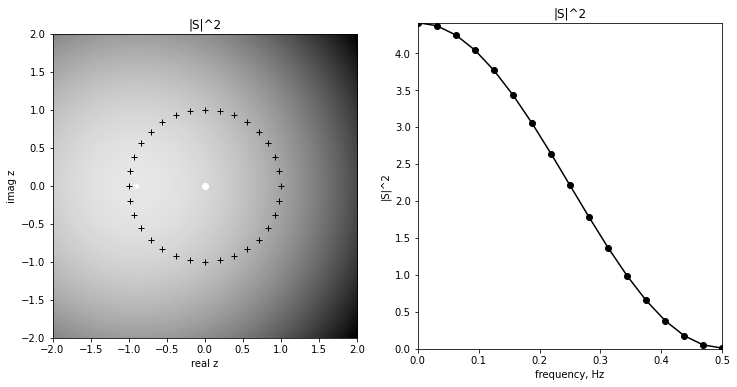

In [13]:
# eda09_11
# complex z-plane analysis of filters, case 1, lowpass

# standard time/frequency setup
N=32;
Dt=1.0;
No2 = floor(N/2);
tmin = 0;
tmax = Dt*(N-1);
t=np.zeros((N,1));
t[:,0]= np.linspace(tmin,tmax,N);
fmax=1/(2.0*Dt);
Df=fmax/No2;
Nf=No2+1;
f=np.zeros((N,1));
f[:,0] = Df * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Dw=2*pi*Df;
w=np.zeros((N,1));
w[:,0] = Dw * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Nw=Nf;
fpos=np.zeros((Nf,1));
fpos[:,0] = Df * np.linspace(0,No2,Nf);
wpos=np.zeros((Nf,1));
wpos[:,0] = Dw * np.linspace(0,No2,Nf);

# a monomial filter, and its one root
F = np.zeros((2,1));
F[:,0] = [1, 1.1];
zp = -F[0,0]/F[1,0];  # 0=F1+F2*z  so z=-F1/F2
print("zero at %.3f" % (zp) );

# complex z-plane
Nz=128;
zmin=-2;
zmax=2;
dz=(zmax-zmin)/(Nz-1);
zr = np.zeros((Nz,1));
zi = np.zeros((Nz,1));
zr[:,0]=np.linspace(zmin,zmax,Nz);
zi[:,0]=np.linspace(zmin,zmax,Nz);

# evaluate filter polynomial everywhere in complex z-plane
S = np.zeros((Nz,Nz));
for n in range(Nz):
    for m in range(Nz):
        S[m,n] = abs( F[0,0] + F[1,0]*(zr[n,0]+complex(0,1)*zi[m,0]) )**2;

# plot amplitude of polynomial
fig1 = plt.figure(1,figsize=(12,6));

# black and white colormap
bw = np.zeros((256,4));
v = 0.9*(256 - np.linspace( 0, 255, 256 ))/255;
bw[:,0] = v;
bw[:,1] = v;
bw[:,2] = v;
bw[:,3] = np.ones(256);
bwcmap = ListedColormap(bw);

ax1 = plt.subplot(1,2,1);
plt.axis( [zmin,zmax,zmin,zmax]);

plt.imshow( S, cmap=bwcmap, vmin=np.min(S), vmax=np.max(S), extent=(zmin,zmax,zmin,zmax) );
plt.xlabel('real z');
plt.ylabel('imag z');
plt.title('|S|^2');

# plot Fourier transform points on the unit circle
plt.plot(0,0,'wo');
z=np.exp(-complex(0,1)*w*Dt);
plt.plot(np.real(z),np.imag(z),'k+');

# plot zero of filter
plt.plot(np.real(zp),np.imag(zp),'w*');

# plot frequency response of filter

Sz = np.abs( F[0,0]+F[1,0]*z )**2;

ax2 = plt.subplot(1,2,2);
plt.axis( [0, fmax, 0, max(Sz)] );

plt.xlabel('frequency, Hz');
plt.ylabel('|S|^2');
plt.title('|S|^2');
plt.plot(fpos,Sz[0:Nf,0],'k-');
plt.plot(fpos,Sz[0:Nf,0],'ko');

plt.show();

poles at (-0.754 -0.830) and (-0.754 0.830)


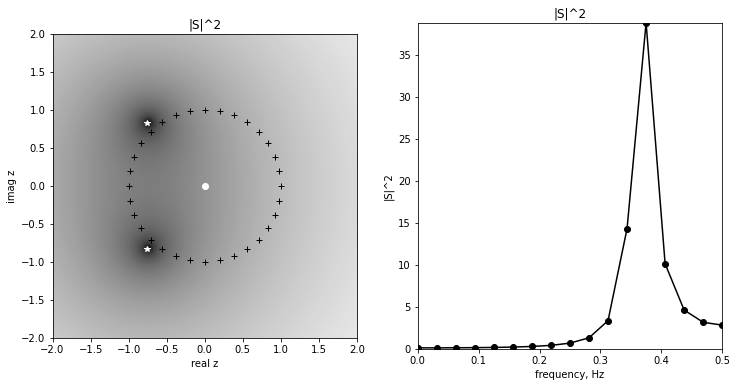

In [14]:
# eda09_12
# complex z-plane analysis of filters, case 3, narrow band

# standard time/frequency setup
N=32;
Dt=1.0;
No2 = floor(N/2);
tmin = 0;
tmax = Dt*(N-1);
t=np.zeros((N,1));
t[:,0]= np.linspace(tmin,tmax,N);
fmax=1/(2.0*Dt);
Df=fmax/No2;
Nf=No2+1;
f=np.zeros((N,1));
f[:,0] = Df * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Dw=2*pi*Df;
w=np.zeros((N,1));
w[:,0] = Dw * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Nw=Nf;
fpos=np.zeros((Nf,1));
fpos[:,0] = Df * np.linspace(0,No2,Nf);
wpos=np.zeros((Nf,1));
wpos[:,0] = Dw * np.linspace(0,No2,Nf);

# a monomial filter, and its one root
F1 = np.zeros((2,1),dtype=np.complex);
F1[:,0] = [1, 0.6*(1-1.1*complex(0.0,1.0))];
zp1 = -F1[0,0]/F1[1,0];  # 0=F1+F2*z  so z=-F1/F2
F2 = np.conj(F1);
zp2 = -F2[0,0]/F2[1,0];
print("poles at (%.3f %.3f) and (%.3f %.3f)" % (np.real(zp1),np.imag(zp1),np.real(zp2),np.imag(zp2)) );

# complex z-plane
Nz=128;
zmin=-2;
zmax=2;
dz=(zmax-zmin)/(Nz-1);
zr = np.zeros((Nz,1));
zi = np.zeros((Nz,1));
zr[:,0]=np.linspace(zmin,zmax,Nz);
zi[:,0]=np.linspace(zmin,zmax,Nz);

# evaluate filter polynomial everywhere in complex z-plane
S = np.zeros((Nz,Nz));
for n in range(Nz):
    for m in range(Nz):
        v1 = 1/(F1[0,0] + F1[1,0]*(zr[n,0]+complex(0.0,1.0)*zi[m,0]));
        v2 = 1/(F2[0,0] + F2[1,0]*(zr[n,0]+complex(0.0,1.0)*zi[m,0]));
        S[m,n] = log( abs( v1*v2 )**2);  # take the log for plot-scaling  purposes

# plot amplitude of polynomial
fig1 = plt.figure(1,figsize=(12,6));

# black and white colormap
bw = np.zeros((256,4));
v = 0.9*(256 - np.linspace( 0, 255, 256 ))/255;
bw[:,0] = v;
bw[:,1] = v;
bw[:,2] = v;
bw[:,3] = np.ones(256);
bwcmap = ListedColormap(bw);

ax1 = plt.subplot(1,2,1);
plt.axis( [zmin,zmax,zmin,zmax]);

plt.imshow( S, cmap=bwcmap, vmin=np.min(S), vmax=np.max(S), extent=(zmin,zmax,zmin,zmax) );
plt.xlabel('real z');
plt.ylabel('imag z');
plt.title('|S|^2');

# plot Fourier transform points on the unit circle
plt.plot(0,0,'wo');
z=np.exp(-complex(0,1)*w*Dt);
plt.plot(np.real(z),np.imag(z),'k+');

# plot poles of filter
plt.plot(np.real(zp1),np.imag(zp1),'w*');
plt.plot(np.real(zp2),np.imag(zp2),'w*');

# plot frequency response of filter
Sz = np.abs( np.reciprocal( np.multiply(F1[0,0]+F1[1,0]*z,F2[0,0]+F2[1,0]*z)) )**2;

ax2 = plt.subplot(1,2,2);
plt.axis( [0, fmax, 0, max(Sz)] );

plt.xlabel('frequency, Hz');
plt.ylabel('|S|^2');
plt.title('|S|^2');
plt.plot(fpos,Sz[0:Nf,0],'k-');
plt.plot(fpos,Sz[0:Nf,0],'ko');

plt.show();

zeros at (-0.000 1.111) and (-0.000 -1.111)
poles at (-0.000 1.250) and (-0.000 -1.250)


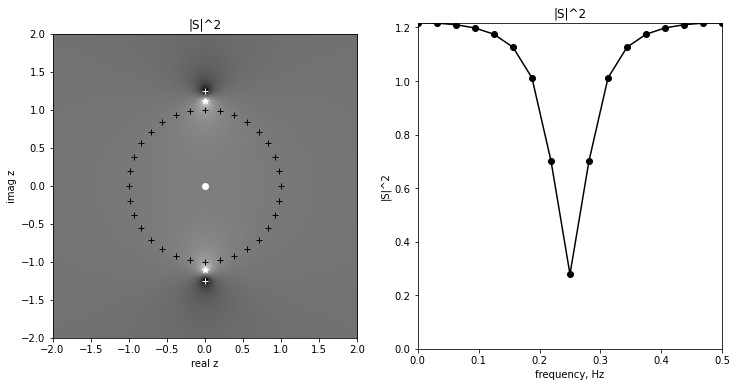

In [15]:
# eda09_13
# complex z-plane analysis of filters, case 4, notch

# standard time/frequency setup
N=32;
Dt=1.0;
No2 = floor(N/2);
tmin = 0;
tmax = Dt*(N-1);
t=np.zeros((N,1));
t[:,0]= np.linspace(tmin,tmax,N);
fmax=1/(2.0*Dt);
Df=fmax/No2;
Nf=No2+1;
f=np.zeros((N,1));
f[:,0] = Df * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Dw=2*pi*Df;
w=np.zeros((N,1));
w[:,0] = Dw * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Nw=Nf;
fpos=np.zeros((Nf,1));
fpos[:,0] = Df * np.linspace(0,No2,Nf);
wpos=np.zeros((Nf,1));
wpos[:,0] = Dw * np.linspace(0,No2,Nf);

# a monomial filter, and its one root
F1 = np.zeros((2,1),dtype=np.complex);
F1[:,0] = [1, 0.9*complex(0.0,1.0)];
zp1 = -F1[0,0]/F1[1,0];  # 0=F1+F2*z  so z=-F1/F2
F2 = np.conj(F1);
zp2 = -F2[0,0]/F2[1,0];
print("zeros at (%.3f %.3f) and (%.3f %.3f)" % (np.real(zp1),np.imag(zp1),np.real(zp2),np.imag(zp2)) );

F3 = np.zeros((2,1),dtype=np.complex);
F3[:,0] = [1, 0.8*complex(0.0,1.0)];
zp3= -F3[0,0]/F3[1,0];  # 0=F1+F2*z  so z=-F1/F2
F4 = np.conj(F3);
zp4 = -F4[0,0]/F4[1,0];
print("poles at (%.3f %.3f) and (%.3f %.3f)" % (np.real(zp3),np.imag(zp3),np.real(zp4),np.imag(zp4)) );

# complex z-plane
Nz=128;
zmin=-2;
zmax=2;
dz=(zmax-zmin)/(Nz-1);
zr = np.zeros((Nz,1));
zi = np.zeros((Nz,1));
zr[:,0]=np.linspace(zmin,zmax,Nz);
zi[:,0]=np.linspace(zmin,zmax,Nz);

# evaluate filter polynomial everywhere in complex z-plane
S = np.zeros((Nz,Nz));
for n in range(Nz):
    for m in range(Nz):
        v1 = (F1[0,0] + F1[1,0]*(zr[n,0]+complex(0.0,1.0)*zi[m,0]));
        v2 = (F2[0,0] + F2[1,0]*(zr[n,0]+complex(0.0,1.0)*zi[m,0]));
        v3 = (F3[0,0] + F3[1,0]*(zr[n,0]+complex(0.0,1.0)*zi[m,0]));
        v4 = (F4[0,0] + F4[1,0]*(zr[n,0]+complex(0.0,1.0)*zi[m,0]));
        S[m,n] = log( abs( (v1*v2)/(v3*v4) )**2);  # take the log for plot-scaling  purposes

# plot amplitude of polynomial
fig1 = plt.figure(1,figsize=(12,6));

# black and white colormap
bw = np.zeros((256,4));
v = 0.9*(256 - np.linspace( 0, 255, 256 ))/255;
bw[:,0] = v;
bw[:,1] = v;
bw[:,2] = v;
bw[:,3] = np.ones(256);
bwcmap = ListedColormap(bw);

ax1 = plt.subplot(1,2,1);
plt.axis( [zmin,zmax,zmin,zmax]);

plt.imshow( S, cmap=bwcmap, vmin=np.min(S), vmax=np.max(S), extent=(zmin,zmax,zmin,zmax) );
plt.xlabel('real z');
plt.ylabel('imag z');
plt.title('|S|^2');

# plot Fourier transform points on the unit circle
plt.plot(0,0,'wo');
z=np.exp(-complex(0,1)*w*Dt);
plt.plot(np.real(z),np.imag(z),'k+');

# plot poles of filter
plt.plot(np.real(zp1),np.imag(zp1),'w*');
plt.plot(np.real(zp2),np.imag(zp2),'w*');
plt.plot(np.real(zp3),np.imag(zp3),'w+');
plt.plot(np.real(zp4),np.imag(zp4),'w+');

# plot frequency response of filter
partA = np.multiply(  F1[0,0]+F1[1,0]*z,  F2[0,0]+F2[1,0]*z);
partB = np.multiply(  F3[0,0]+F3[1,0]*z,  F4[0,0]+F4[1,0]*z);
Sz = np.abs(np.divide(partA, partB))**2;

ax2 = plt.subplot(1,2,2);
plt.axis( [0, fmax, 0, max(Sz)] );

plt.xlabel('frequency, Hz');
plt.ylabel('|S|^2');
plt.title('|S|^2');
plt.plot(fpos,Sz[0:Nf,0],'k-');
plt.plot(fpos,Sz[0:Nf,0],'ko');

plt.show();

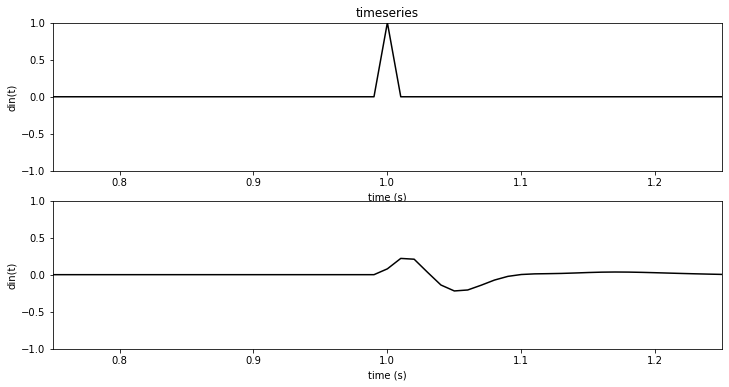

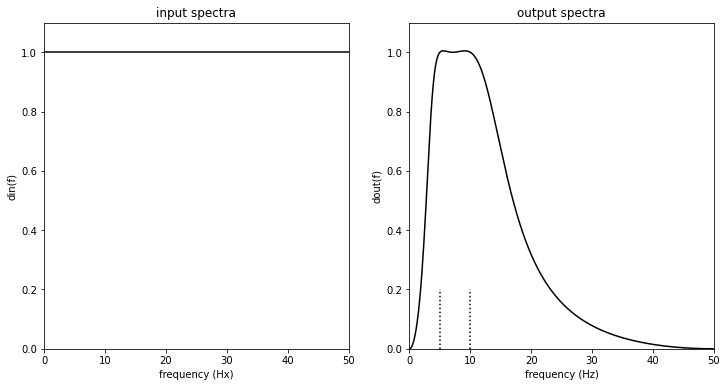

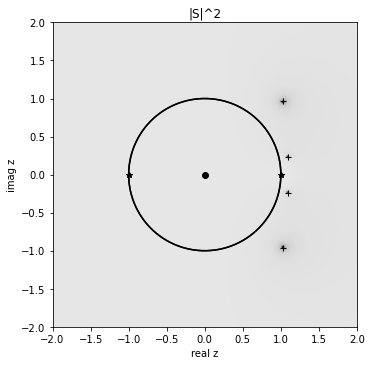

In [16]:
# eda09_14
# example of Chebychev bandpass filter

# limits of bandpass filter
flow=5;
fhigh=10;

# standard time/frequency setup
N=1024;
Dt=0.01;
Nf=N/2+1;
No2 = floor(N/2);
tmin = 0;
tmax = Dt*(N-1);
t=np.zeros((N,1));
t[:,0]= np.linspace(tmin,tmax,N);
fmax=1/(2.0*Dt);
Df=fmax/No2;
Nf=No2+1;
f=np.zeros((N,1));
f[:,0] = Df * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Dw=2*pi*Df;
w=np.zeros((N,1));
w[:,0] = Dw * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Nw=Nf;
fpos=np.zeros((Nf,1));
fpos[:,0] = Df * np.linspace(0,No2,Nf);
wpos=np.zeros((Nf,1));
wpos[:,0] = Dw * np.linspace(0,No2,Nf);

# input timeseries is a spike
din=np.zeros((N,1));
din[100,0]=1;

# filter
[dout, u, v] = chebyshevfilt( din, Dt, flow, fhigh);

#  spectrum of input
dint = np.zeros( (N,1), dtype=np.cdouble);
dint[:,0] = np.fft.fft(din, axis=0).ravel();
dintpos = np.zeros( (Nf,1), dtype=np.cdouble);
dintpos[:,0] = dint[0:Nf,0];
dinspec = np.abs(dintpos);

#  spectrum of output
doutt = np.zeros( (N,1), dtype=np.cdouble);
doutt[:,0] = np.fft.fft(dout, axis=0).ravel();
# delete negative frequencies
douttpos = np.zeros( (Nf,1), dtype=np.cdouble);
douttpos[:,0] = doutt[0:Nf,0];
doutspec = np.abs(douttpos);

# plot unfiltered and filtered timeseries
fig1 = plt.figure(1,figsize=(12,6));
ax1 = plt.subplot(2,1,1);
plt.axis( [0.75, 1.25, -1, 1 ]);
plt.plot(t, din, 'k-' );
plt.xlabel('time (s)');
plt.ylabel('din(t)');
plt.title('timeseries');
ax2 = plt.subplot(2,1,2);
plt.axis( [0.75, 1.25, -1, 1 ]);
plt.plot(t, dout, 'k-' );
plt.xlabel('time (s)');
plt.ylabel('din(t)');
plt.show();

# plot spectra
fig2 = plt.figure(2,figsize=(12,6));
ax1 = plt.subplot(1,2,1);
specmax=np.max(dinspec);
plt.axis( [0, fmax, 0, 1.1*specmax ]);
plt.plot(fpos, dinspec, 'k-' );
plt.xlabel('frequency (Hx)');
plt.ylabel('din(f)');
plt.title('input spectra');
ax2 = plt.subplot(1,2,2);
plt.axis( [0, fmax, 0, 1.1*specmax ]);
plt.plot(fpos, doutspec, 'k-' );
plt.xlabel('frequency (Hz)');
plt.ylabel('dout(f)');
plt.title('output spectra');
plt.plot( [flow, flow], [0, 0.2*specmax], 'k:' );
plt.plot( [fhigh, fhigh], [0, 0.2*specmax], 'k:' );
plt.show();

# roots of filters
[Nu, i] = np.shape(u);
Nru = Nu-1;
pol = (np.flipud(u)).ravel();
ru = np.zeros((Nru,1),dtype=np.complex);
ru[:,0] = np.roots(pol);

[Nv,i] = np.shape(v);
Nrv = Nv-1;
pol = (np.flipud(v)).ravel();
rv = np.zeros((Nrv,1),dtype=np.complex);
rv[:,0] = np.roots(pol);


# complex z-plane
Nz=128;
zmin=-2;
zmax=2;
dz=(zmax-zmin)/(Nz-1);
zr = np.zeros((Nz,1));
zi = np.zeros((Nz,1));
zr[:,0]=np.linspace(zmin,zmax,Nz);
zi[:,0]=np.linspace(zmin,zmax,Nz);


# evaluate filter polynomials everywhere in complex z-plane
S = np.zeros((Nz,Nz));
for n in range(Nz):
    for m in range(Nz):
        z = zr[n,0]+complex(0.0,1.0)*zi[m,0];
        uu=0.0;
        zpow=1;
        for k in range(Nu):
            uu = uu + u[k,0]*zpow;
            zpow=zpow*z;
        vv=0.0;
        zpow=1;
        for k in range(Nv):
            vv = vv + v[k,0]*zpow;
            zpow=zpow*z;
        SS = uu/vv;
        S[m,n]=np.abs(SS);

# plot amplitude of polynomial
fig3 = plt.figure(3,figsize=(12,6));

# black and white colormap
bw = np.zeros((256,4));
v = 0.9*(256 - np.linspace( 0, 255, 256 ))/255;
bw[:,0] = v;
bw[:,1] = v;
bw[:,2] = v;
bw[:,3] = np.ones(256);
bwcmap = ListedColormap(bw);

ax1 = plt.subplot(1,2,1);
plt.axis( [zmin,zmax,zmin,zmax]);

plt.imshow( S, cmap=bwcmap, vmin=np.min(S), vmax=np.max(S), extent=(zmin,zmax,zmin,zmax) );
plt.xlabel('real z');
plt.ylabel('imag z');
plt.title('|S|^2');

# plot Fourier transform points on the unit circle
plt.plot(0,0,'wo');
z=np.exp(-complex(0,1)*w*Dt);
plt.plot(np.real(z),np.imag(z),'k-');

# plot origin
plt.plot(0,0,'ko');
# plot unit circle
z=np.exp(-complex(0.0,1.0)*w*Dt);
plt.plot(np.real(z),np.imag(z),'k-');

# plot zeros and poles
for k in range(Nru):
    plt.plot(np.real(ru[k,0]),np.imag(ru[k,0]),'k*');

for k in range(Nrv):
    plt.plot(np.real(rv[k,0]),np.imag(rv[k,0]),'k+');

plt.show();
        

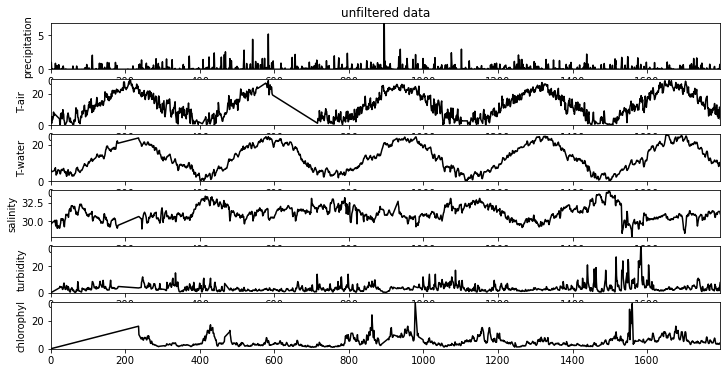

In [17]:
# eda09_15
# read Reynolds Channel Water Quality dataset and plot it
# columns are days, precip, air_temp, water_temp, salinity, turbidity, chlorophyl


# load data
D = np.genfromtxt('reynolds_interpolated.txt', delimiter='\t')
[N, M]=D.shape;
t = np.zeros((N,1));
t[:,0] = D[:,0];         # time in days 
Dt=t[1,0]-t[0,0];
tmin = t[0,0];
tmax = t[N-1,0];

# rename
p = np.zeros((N,1));
at = np.zeros((N,1));
wt = np.zeros((N,1));
s = np.zeros((N,1));
tb = np.zeros((N,1));
c = np.zeros((N,1));
p[:,0] = D[:,1];        # precipitation, inches
at[:,0] = D[:,2];       # air temperature, deg C
wt[:,0] = D[:,3];       # water temperature, deg C
s[:,0] = D[:,4];        # salinity, practical salinity units
tb[:,0] = D[:,5];       # turbidity, (no units given)
c[:,0] = D[:,6];        # chlorophyl, micrograms per liter

fig1 = plt.figure(1,figsize=(12,6));

# plotting limits
itmin=0;
itmax=N;
tmin=t[itmin];
tmax=t[itmax-1];

ax1 = plt.subplot(6,1,1);
plt.axis( [tmin, tmax, np.min(p[itmin:itmax,0]), np.max(p[itmin:itmax,0])]);
plt.plot(t, p, 'k-' );
plt.ylabel('precipitation');
plt.title('unfiltered data');

ax2 = plt.subplot(6,1,2);
plt.axis( [tmin, tmax, np.min(at[itmin:itmax,0]), np.max(at[itmin:itmax,0])]);
plt.plot(t, at, 'k-' );
plt.ylabel('T-air');
      
ax3 = plt.subplot(6,1,3);
plt.axis( [tmin, tmax, np.min(wt[itmin:itmax,0]), np.max(wt[itmin:itmax,0])]);
plt.plot(t, wt, 'k-' );
plt.ylabel('T-water');

ax4 = plt.subplot(6,1,4);
plt.axis( [tmin, tmax, np.min(s[itmin:itmax,0]), np.max(s[itmin:itmax,0])]);
plt.plot(t, s, 'k-' );
plt.ylabel('salinity');

ax5 = plt.subplot(6,1,5);
plt.axis( [tmin, tmax, np.min(tb[itmin:itmax,0]), np.max(tb[itmin:itmax,0])]);
plt.plot(t, tb, 'k-' );
plt.ylabel('turbidity');

ax6 = plt.subplot(6,1,6);
plt.axis( [tmin, tmax, np.min(c[itmin:itmax,0]), np.max(c[itmin:itmax,0])]);
plt.plot(t, c, 'k-' );
plt.ylabel('chlorophyl');


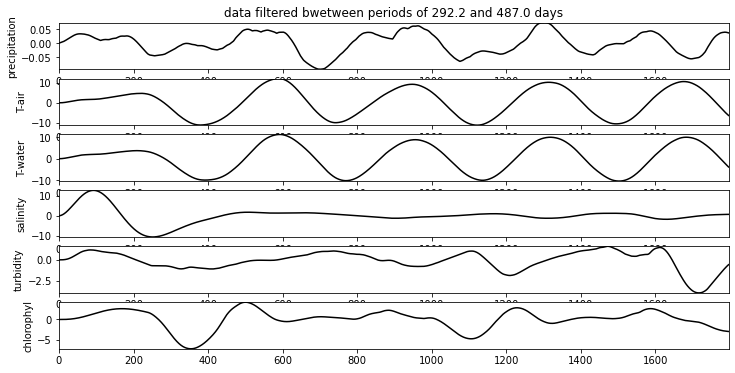

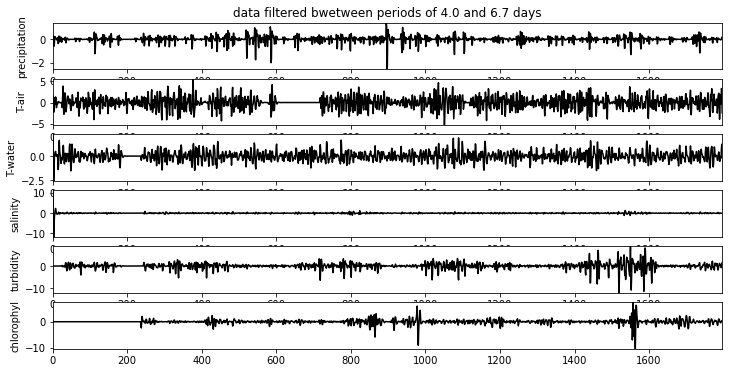

In [19]:
# eda09_16
# read Reynolds Channel Water Quality dataset and plot it
# columns are days, precip, air_temp, water_temp, salinity, turbidity, chlorophyl

# load data
D = np.genfromtxt('reynolds_interpolated.txt', delimiter='\t')
[N, M]=D.shape;
t = np.zeros((N,1));
t[:,0] = D[:,0];         # time in days 
Dt=t[1,0]-t[0,0];
tmin = t[0,0];
tmax = t[N-1,0];

# low pass filter
fcenter = 1/365.25;
flow = 0.75*fcenter;
fhigh =1.25*fcenter;

# bandpass filter
d = np.zeros((N,1));
Df = np.zeros((N,M));
Df[:,0] = D[:,0];
for i in range(1,M):
    d[:,0] = D[:,i];
    [z, u, v] = chebyshevfilt(d, Dt, flow, fhigh);
    Df[:,i] = z.ravel();

# rename
p = np.zeros((N,1));
at = np.zeros((N,1));
wt = np.zeros((N,1));
s = np.zeros((N,1));
tb = np.zeros((N,1));
c = np.zeros((N,1));
p[:,0] = Df[:,1];        # precipitation, inches
at[:,0] = Df[:,2];       # air temperature, deg C
wt[:,0] = Df[:,3];       # water temperature, deg C
s[:,0] = Df[:,4];        # salinity, practical salinity units
tb[:,0] = Df[:,5];       # turbidity, (no units given)
c[:,0] = Df[:,6];        # chlorophyl, micrograms per liter

fig1 = plt.figure(1,figsize=(12,6));

# plotting limits
itmin=0;
itmax=N;
tmin=t[itmin];
tmax=t[itmax-1];

ax1 = plt.subplot(6,1,1);
plt.axis( [tmin, tmax, np.min(p[itmin:itmax,0]), np.max(p[itmin:itmax,0])]);
plt.plot(t, p, 'k-' );
plt.ylabel('precipitation');
plt.title("data filtered bwetween periods of %.1f and %.1f days" % (1/fhigh,1/flow) );

ax2 = plt.subplot(6,1,2);
plt.axis( [tmin, tmax, np.min(at[itmin:itmax,0]), np.max(at[itmin:itmax,0])]);
plt.plot(t, at, 'k-' );
plt.ylabel('T-air');
      
ax3 = plt.subplot(6,1,3);
plt.axis( [tmin, tmax, np.min(wt[itmin:itmax,0]), np.max(wt[itmin:itmax,0])]);
plt.plot(t, wt, 'k-' );
plt.ylabel('T-water');

ax4 = plt.subplot(6,1,4);
plt.axis( [tmin, tmax, np.min(s[itmin:itmax,0]), np.max(s[itmin:itmax,0])]);
plt.plot(t, s, 'k-' );
plt.ylabel('salinity');

ax5 = plt.subplot(6,1,5);
plt.axis( [tmin, tmax, np.min(tb[itmin:itmax,0]), np.max(tb[itmin:itmax,0])]);
plt.plot(t, tb, 'k-' );
plt.ylabel('turbidity');

ax6 = plt.subplot(6,1,6);
plt.axis( [tmin, tmax, np.min(c[itmin:itmax,0]), np.max(c[itmin:itmax,0])]);
plt.plot(t, c, 'k-' );
plt.ylabel('chlorophyl');

plt.show();

fcenter = 1/5;
flow = 0.75*fcenter;
fhigh =1.25*fcenter;


# bandpass filter
d = np.zeros((N,1));
Df = np.zeros((N,M));
Df[:,0] = D[:,0];
for i in range(1,M):
    d[:,0] = D[:,i];
    [z, u, v] = chebyshevfilt(d, Dt, flow, fhigh);
    Df[:,i] = z.ravel();

# rename
p = np.zeros((N,1));
at = np.zeros((N,1));
wt = np.zeros((N,1));
s = np.zeros((N,1));
tb = np.zeros((N,1));
c = np.zeros((N,1));
p[:,0] = Df[:,1];        # precipitation, inches
at[:,0] = Df[:,2];       # air temperature, deg C
wt[:,0] = Df[:,3];       # water temperature, deg C
s[:,0] = Df[:,4];        # salinity, practical salinity units
tb[:,0] = Df[:,5];       # turbidity, (no units given)
c[:,0] = Df[:,6];        # chlorophyl, micrograms per liter

fig1 = plt.figure(1,figsize=(12,6));

# plotting limits
itmin=0;
itmax=N;
tmin=t[itmin];
tmax=t[itmax-1];

ax1 = plt.subplot(6,1,1);
plt.axis( [tmin, tmax, np.min(p[itmin:itmax,0]), np.max(p[itmin:itmax,0])]);
plt.plot(t, p, 'k-' );
plt.ylabel('precipitation');
plt.title("data filtered bwetween periods of %.1f and %.1f days" % (1/fhigh,1/flow) );

ax2 = plt.subplot(6,1,2);
plt.axis( [tmin, tmax, np.min(at[itmin:itmax,0]), np.max(at[itmin:itmax,0])]);
plt.plot(t, at, 'k-' );
plt.ylabel('T-air');
      
ax3 = plt.subplot(6,1,3);
plt.axis( [tmin, tmax, np.min(wt[itmin:itmax,0]), np.max(wt[itmin:itmax,0])]);
plt.plot(t, wt, 'k-' );
plt.ylabel('T-water');

ax4 = plt.subplot(6,1,4);
plt.axis( [tmin, tmax, np.min(s[itmin:itmax,0]), np.max(s[itmin:itmax,0])]);
plt.plot(t, s, 'k-' );
plt.ylabel('salinity');

ax5 = plt.subplot(6,1,5);
plt.axis( [tmin, tmax, np.min(tb[itmin:itmax,0]), np.max(tb[itmin:itmax,0])]);
plt.plot(t, tb, 'k-' );
plt.ylabel('turbidity');

ax6 = plt.subplot(6,1,6);
plt.axis( [tmin, tmax, np.min(c[itmin:itmax,0]), np.max(c[itmin:itmax,0])]);
plt.plot(t, c, 'k-' );
plt.ylabel('chlorophyl');

plt.show();


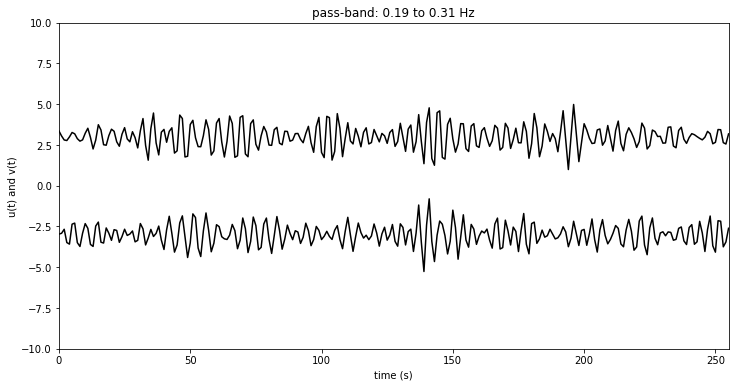

Calculated directly from the band-passed time series:
    Power in u 135.5316
    Power in v 111.6280
    Zero-lag cross correlation 66.1322
    Curly C squared 0.2891
 
Calculated from the cross spectral density
    Pover in u 135.5316
    Pover in v 111.6280
    Zero-lag cross correlation 66.1322
    Curly C squared 0.2891
    Coherence 0.2972


In [20]:
# eda09_17
# cohernce calculation (single frequency band only)
# as a check of the formula for C

# time definitions
N=256;
Dt=1;
t = np.zeros((N,1));
t[:,0] = Dt*np.linspace(0,N-1,N);

# random time series
rts1=np.random.normal( 0.0, 1.0, (256, 1) );
rts2=np.random.normal( 0.0, 1.0, (256, 1) );
rts3=np.random.normal( 0.0, 1.0, (256, 1) );

# create partially correlated time series
uorig = rts1 + rts2;
vorig = rts1 + rts3;

# frequency definition
fmax=1/(2.0*Dt);
No2 = floor(N/2);
Df=fmax/No2;
Nf=No2+1;
f=np.zeros((N,1));
f[:,0] = Df * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Dw=2*pi*Df;
w=np.zeros((N,1));
w[:,0] = Dw * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Nw=Nf;
fpos=np.zeros((Nf,1));
fpos[:,0] = Df * np.linspace(0,No2,Nf);
wpos=np.zeros((Nf,1));
wpos[:,0] = Dw * np.linspace(0,No2,Nf);

# frequency and bandwith for calculation
f0 = fmax/2;
lowside = 0.75;
highside =1.25;
flow = f0*lowside;
fhigh= f0*highside;
ilow = floor(flow/Df);
ihigh = floor(fhigh/Df);

# box car filter matching the parameters above
bp = np.zeros((N,1));
bp[ilow:ihigh]=1.0;
bp[N-ihigh+1:N-ilow+1]=1.0;

# bandpass filter the data
ufilt = np.zeros((N,1));
vfilt = np.zeros((N,1));
ufilt[:,0] = np.real( np.fft.ifft( np.multiply( bp.ravel(), np.fft.fft(uorig.ravel()) ) ) );
vfilt[:,0] = np.real( np.fft.ifft( np.multiply( bp.ravel(), np.fft.fft(vorig.ravel()) ) ) );

# calculation of power and zero-lag cross-correlation
Pu = np.sum( np.power(ufilt,2) );
Pv = np.sum( np.power(vfilt,2) );
x = np.correlate( ufilt.ravel(), vfilt.ravel(), mode='full' );
x0 = x[N-1];

# plot time series
fig1 = plt.figure(1,figsize=(12,6));
ax1 = plt.subplot(1,1,1);
plt.axis( [t[0,0], t[N-1,0], -10, 10 ] );
plt.plot(t, ufilt+3, 'k-' );
plt.plot(t, vfilt-3, 'k-' );
plt.xlabel('time (s)');
plt.ylabel('u(t) and v(t)');
plt.title("pass-band: %.2f to %.2f Hz" % (flow, fhigh));
plt.show();

# display results
print('Calculated directly from the band-passed time series:');
print("    Power in u %.4f" % (Pu) );
print("    Power in v %.4f" % (Pv) );
print("    Zero-lag cross correlation %.4f" % (x0) );
print("    Curly C squared %.4f" % ((x0**2)/(Pu*Pv)) );
print(' ');

# Fourier transform
ut = np.zeros((N,1),dtype=np.complex);
ut[:,0] = np.fft.fft(uorig.ravel());
u = np.zeros((Nf,1),dtype=np.complex);
u[:,0] = ut[0:Nf,0]; # delete negative frequencies

vt = np.zeros((N,1),dtype=np.complex);
vt[:,0] = np.fft.fft(vorig.ravel());
v = np.zeros((Nf,1),dtype=np.complex);
v[:,0] = vt[0:Nf,0]; # delete negative frequencies

# spectral densities
usv = np.multiply( np.conj(u), v ); # cross spectral density of u and v
usu = np.real( np.multiply( np.conj(u), u ) ); # power spectral density of u
vsv = np.real( np.multiply( np.conj(v), v ) ); # power spectral density of v

# band-averaged quantities
usva = np.sum( (usv[ilow:ihigh,0]) ) / (Nf-1);
usvar = np.sum( np.real( (usv[ilow:ihigh,0] ) ) )/ (Nf-1);
usua = np.sum( usu[ilow:ihigh,0] )/ (Nf-1);
vsva = np.sum( vsv[ilow:ihigh,0] )/ (Nf-1);
curlyc2 = np.multiply( np.conj(usvar), usvar) / (usua * vsva);
coherence = np.real(np.multiply(np.conj(usva),usva)) / (usua * vsva);

# display quantities
print('Calculated from the cross spectral density');
print("    Pover in u %.4f" % (usua));
print("    Pover in v %.4f" % (vsva));
print("    Zero-lag cross correlation %.4f" % (usvar));
print("    Curly C squared %.4f" % (curlyc2));
print("    Coherence %.4f" % (coherence));

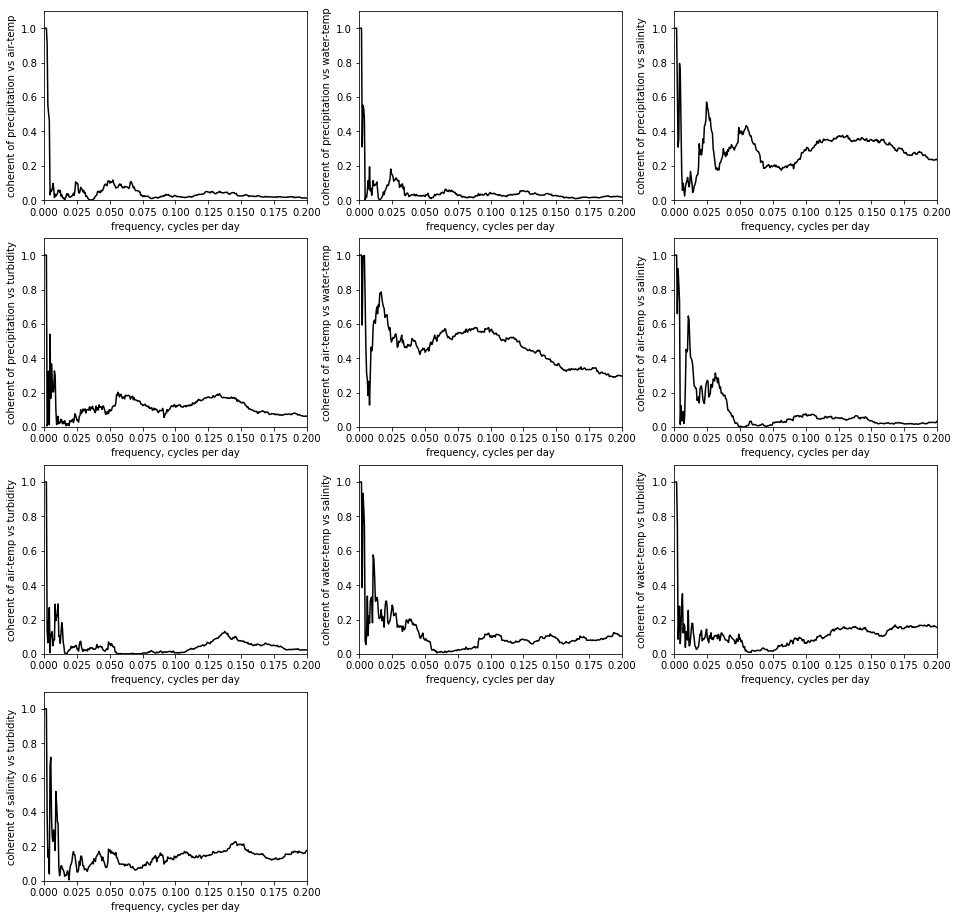

In [21]:
# eda09_18
# read Reynolds Channel Water Quality dataset
# columns are days, precip, air_temp, water_temp, salinity, turbidity, chlorophyl
# compute coherence and plot it

# set DOCOHEREENCE to 1 to add results from the scipy.signal.coherence() function
# (which are plotted in red).  Set to 0 to omit them.
DOCOHEREENCE = 0;

# this is an example of tupple used here to hold the names of the variables
names = ('time', 'precipitation', 'air-temp', 'water-temp', 'salinity', 'turbidity', 'chlorophyll');

# load data
Draw = np.genfromtxt('reynolds_interpolated.txt', delimiter='\t')
[N, M] = Draw.shape;
N = 2*floor(N/2); # truncate to enev length
D = np.zeros((N,M));
D[:,:] = Draw[0:N,:];

# time in days 
t = np.zeros((N,1));
t[:,0] = D[:,0];
Dt=t[1,0]-t[0,0];
tmin = t[0,0];
tmax = t[N-1,0];

# standard frequency setup
Nf = floor(N/2+1);
fny = 1/(2*Dt);
Df = fny/(N/2);
f = np.zeros((Nf,1)); # positive frequencies
f[:,0] = np.linspace(0.0,fny,Nf);

# bandwidth factors
lowside = 0.75;
highside =1.25;

ifig=1;
fig1 = plt.figure(1,figsize=(16,16));

# loop over all pairs of columns, computing coherence for each
for icol in range(1,M):
    for jcol in range(icol+1,M-1):
        # compute cross spectral density and power spectral density
        # no need to normalize, since all normalizations cancel
        ut = np.zeros((N,1), dtype=np.complex );
        vt = np.zeros((N,1), dtype=np.complex );
        ut[:,0] = np.fft.fft( D[:,icol] );
        vt[:,0] = np.fft.fft( D[:,jcol] );
        u = np.zeros((Nf,1), dtype=np.complex );
        v = np.zeros((Nf,1), dtype=np.complex );
        u[:,0] = ut[0:Nf,0]; # delete negative frequencies
        v[:,0] = vt[0:Nf,0];
        usv = np.zeros((Nf,1), dtype=np.complex );
        usu = np.zeros((Nf,1));
        vsv = np.zeros((Nf,1));
        usv[:,0] = np.multiply( np.conj(u) , v ).ravel(); # cross spectral density of u and v
        usu[:,0] = np.real( np.multiply( np.conj(u) , u ) ).ravel(); # power spectral density of u
        vsv[:,0] = np.real( np.multiply( np.conj(v) , v ) ).ravel(); # power spectral density of v
        # average over band
        usva = np.zeros((Nf,1), dtype=np.complex );
        usua = np.zeros((Nf,1));
        vsva = np.zeros((Nf,1)); 
        c = np.zeros((Nf,1)); 
        for i in range(Nf):
            fi = i*Df; # center frequency
            flow = lowside*fi;
            fhigh = highside*fi;
            ilow = floor(flow/Df);
            ihigh = floor(fhigh/Df);
            if( ihigh==ilow):
                ihigh=ilow+1;
            if (ilow < 0):
                ilow=0;
            elif (ilow > Nf):
                ilow=Nf-1;
            if (ihigh < 0):
                ihigh=0;
            elif (ihigh > Nf):
                ihigh=Nf;
            tmp1 = np.mean( usv[ilow:ihigh,0] );
            tmp2 = np.mean( usu[ilow:ihigh,0] );
            tmp3 = np.mean( vsv[ilow:ihigh,0] );
            usva[i,0] = tmp1;
            usua[i,0] = tmp2;
            vsva[i,0] = tmp3;
            
            top = np.real( np.conj(tmp1) * tmp1 );
            bottom = (tmp2 * tmp3);
            if( bottom > 0.0 ):
                c[i,0] =  top / bottom;
            else:
                c[i,0] = 0.0;
        # plot coherence
        ax1 = plt.subplot(4,3,ifig);
        plt.axis( [0, 1/5, 0, 1.1] );
        plt.plot(f, c, 'k-' );
        plt.ylabel("coherent of %s vs %s" % (names[icol],names[jcol]));
        plt.xlabel('frequency, cycles per day');
        if( DOCOHEREENCE == 1):
            # result using mscohere() (plotted in red)
            # the black and red traced will not agree
            # perfectly, because the bandwidth parameters
            # cannot be made to match, expecially at low frequencies.
            N2 = 2;
            while (N2 < N ): # find smallest power of 2 greater than N
                N2 = 2*N2;
            N3 = floor(N2/16);
            N4 = 3;
            [f2, C2] = sg.coherence( D[:,icol], D[:,jcol], nfft=N2, window='hamming', nperseg=N3, noverlap=N3-N4 );
            f2max = np.max(f2);
            plt.plot( (fny/f2max)*f2, C2, 'r:');
        ifig=ifig+1;

plt.show();


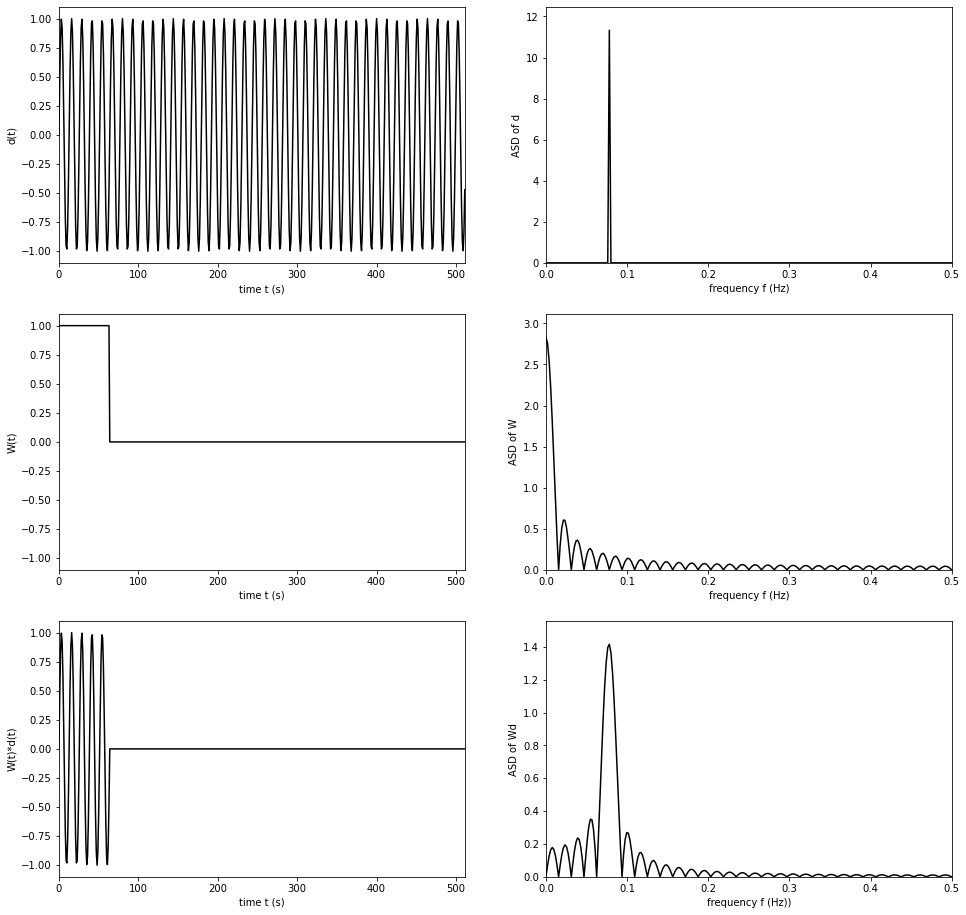

In [22]:
# eda09_19
# demonsrate effect of windowing on power spectral density
# boxcar window

# standard time/frequency definitions
N=512;
Dt=1.0;
t = np.zeros((N,1));
t[:,0] = Dt*np.linspace(0,N-1,N);
tmin = t[0,0];
tmax=t[N-1,0];
fmax=1/(2.0*Dt);
No2 = floor(N/2);
Df=fmax/No2;
Nf=No2+1;
f=np.zeros((N,1));
f[:,0] = Df * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Dw=2*pi*Df;
w=np.zeros((N,1));
w[:,0] = Dw * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Nw=Nf;
fpos=np.zeros((Nf,1));
fpos[:,0] = Df * np.linspace(0,No2,Nf);
wpos=np.zeros((Nf,1));
wpos[:,0] = Dw * np.linspace(0,No2,Nf);

# boxcar window function, W
W = np.zeros((N,1));
No8 = floor(N/8);
W[0:No8,0]=1;
Wtmax = tmax/8;

# timeseriee
w0 = 40*Dw;
d = np.sin( w0 * t );

# windowed timeseries
Wd = np.zeros((N,1));
Wd[:,0] = np.multiply( W, d ).ravel();

# fourier transform
dfft = np.zeros((N,1), dtype=np.complex );
Wfft = np.zeros((N,1), dtype=np.complex );
Wdfft = np.zeros((N,1), dtype=np.complex );
dfft[:,0] = np.fft.fft(d.ravel());
Wfft[:,0] = np.fft.fft(W.ravel());
Wdfft[:,0] = np.fft.fft(Wd.ravel());

# power spectral density
norm = (Dt**2)/tmax;
ds = np.zeros((Nf,1));
Ws = np.zeros((Nf,1));
Wds = np.zeros((Nf,1));
ds[:,0]=norm*np.power(abs(dfft[0:Nf,0]),2);
Ws[:,0]=norm*np.power(abs(Wfft[0:Nf,0]),2);
Wds[:,0]=norm*np.power(abs(Wdfft[0:Nf,0]),2);

# time domain plot
fig1 = plt.figure(1,figsize=(16,16));
                       
ax1 = plt.subplot(3,2,1);
plt.axis( [0, tmax, -1.1, 1.1] );
plt.plot(t, d, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('d(t)');
                       
ax3 = plt.subplot(3,2,3);
plt.axis( [0, tmax, -1.1, 1.1] );
plt.plot(t, W, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('W(t)');
                       
ax5 = plt.subplot(3,2,5);
plt.axis( [0, tmax, -1.1, 1.1] );
plt.plot(t, Wd, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('W(t)*d(t)');    

                     
# frequency domain plot
ax2 = plt.subplot(3,2,2);
plt.axis( [0, fmax, 0, 1.1*np.max(np.sqrt(ds))] );
plt.plot(fpos, np.sqrt(ds), 'k-' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('ASD of d');
                       
ax4 = plt.subplot(3,2,4);
plt.axis( [0, fmax, 0, 1.1*np.max(np.sqrt(Ws))] );
plt.plot(fpos, np.sqrt(Ws), 'k-' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('ASD of W');
                       
ax5 = plt.subplot(3,2,6);
plt.axis( [0, fmax, 0, 1.1*np.max(np.sqrt(Wds))] );
plt.plot( fpos, np.sqrt(Wds), 'k-' );
plt.xlabel('frequency f (Hz))');                 
plt.ylabel('ASD of Wd');                     
                       


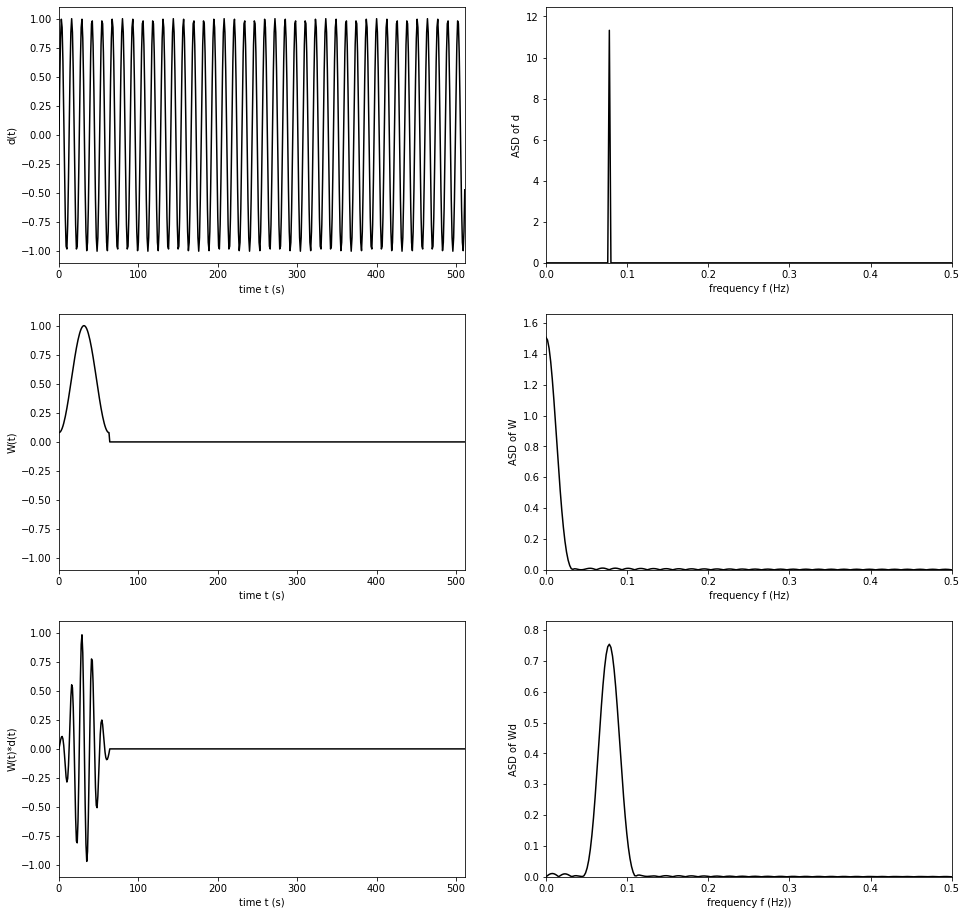

In [23]:
# eda09_20
# demonsrate effect of windowing on power spectral density
# Hamming window

# standard time/frequency definitions
N=512;
Dt=1.0;
t = np.zeros((N,1));
t[:,0] = Dt*np.linspace(0,N-1,N);
tmin = t[0,0];
tmax=t[N-1,0];
fmax=1/(2.0*Dt);
No2 = floor(N/2);
Df=fmax/No2;
Nf=No2+1;
f=np.zeros((N,1));
f[:,0] = Df * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Dw=2*pi*Df;
w=np.zeros((N,1));
w[:,0] = Dw * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Nw=Nf;
fpos=np.zeros((Nf,1));
fpos[:,0] = Df * np.linspace(0,No2,Nf);
wpos=np.zeros((Nf,1));
wpos[:,0] = Dw * np.linspace(0,No2,Nf);

# Hamming window function, W
W = np.zeros((N,1));
Nw = floor(N/8);
W[0:Nw,0]=0.54-0.46*np.cos(2*pi*np.linspace(0,Nw-1,Nw)/(Nw-1));

# timeseriee
w0 = 40*Dw;
d = np.sin( w0 * t );

# windowed timeseries
Wd = np.zeros((N,1));
Wd[:,0] = np.multiply( W, d ).ravel();

# fourier transform
dfft = np.zeros((N,1), dtype=np.complex );
Wfft = np.zeros((N,1), dtype=np.complex );
Wdfft = np.zeros((N,1), dtype=np.complex );
dfft[:,0] = np.fft.fft(d.ravel());
Wfft[:,0] = np.fft.fft(W.ravel());
Wdfft[:,0] = np.fft.fft(Wd.ravel());

# power spectral density
norm = (Dt**2)/tmax;
ds = np.zeros((Nf,1));
Ws = np.zeros((Nf,1));
Wds = np.zeros((Nf,1));
ds[:,0]=norm*np.power(abs(dfft[0:Nf,0]),2);
Ws[:,0]=norm*np.power(abs(Wfft[0:Nf,0]),2);
Wds[:,0]=norm*np.power(abs(Wdfft[0:Nf,0]),2);

# time domain plot
fig1 = plt.figure(1,figsize=(16,16));
                       
ax1 = plt.subplot(3,2,1);
plt.axis( [0, tmax, -1.1, 1.1] );
plt.plot(t, d, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('d(t)');
                       
ax3 = plt.subplot(3,2,3);
plt.axis( [0, tmax, -1.1, 1.1] );
plt.plot(t, W, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('W(t)');
                       
ax5 = plt.subplot(3,2,5);
plt.axis( [0, tmax, -1.1, 1.1] );
plt.plot(t, Wd, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('W(t)*d(t)');    

                     
# frequency domain plot
ax2 = plt.subplot(3,2,2);
plt.axis( [0, fmax, 0, 1.1*np.max(np.sqrt(ds))] );
plt.plot(fpos, np.sqrt(ds), 'k-' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('ASD of d');
                       
ax4 = plt.subplot(3,2,4);
plt.axis( [0, fmax, 0, 1.1*np.max(np.sqrt(Ws))] );
plt.plot(fpos, np.sqrt(Ws), 'k-' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('ASD of W');
                       
ax5 = plt.subplot(3,2,6);
plt.axis( [0, fmax, 0, 1.1*np.max(np.sqrt(Wds))] );
plt.plot( fpos, np.sqrt(Wds), 'k-' );
plt.xlabel('frequency f (Hz))');                 
plt.ylabel('ASD of Wd');                     
                       


6 largest eigenvalues:
    59: 1.724369
    60: 4.536603
    61: 6.029180
    62: 6.268016
    63: 6.282832


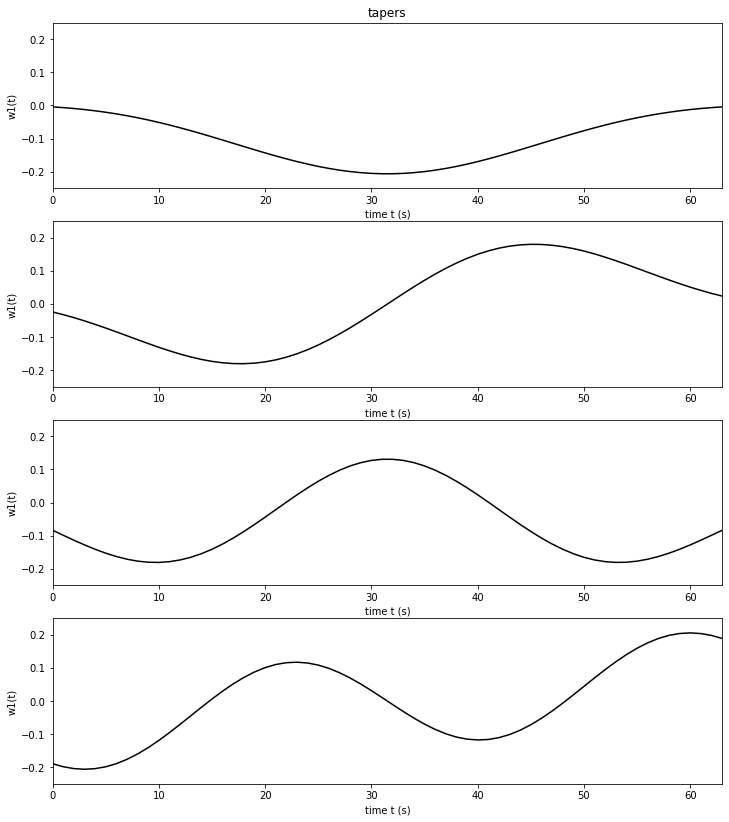

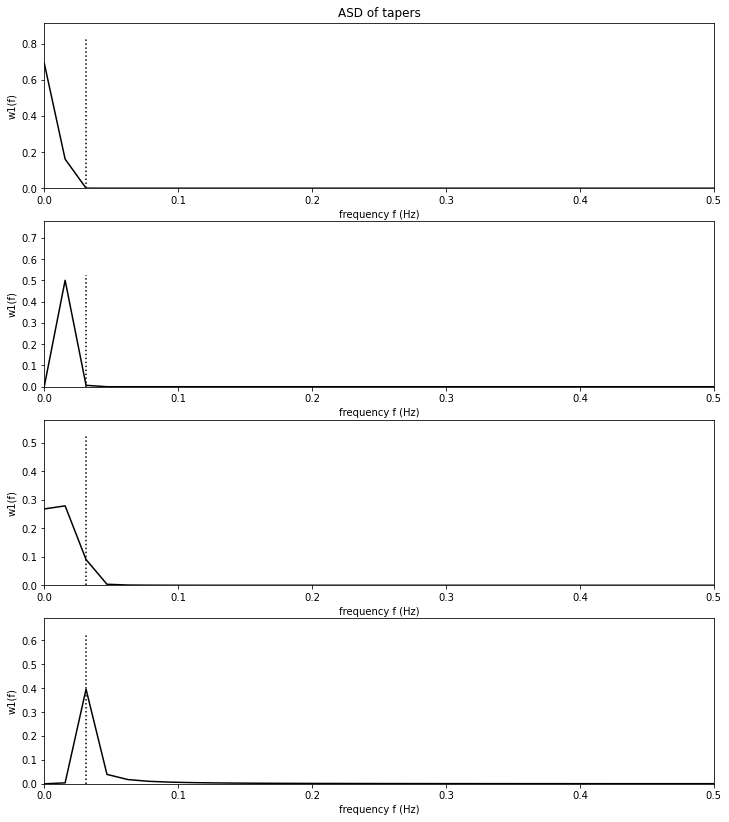

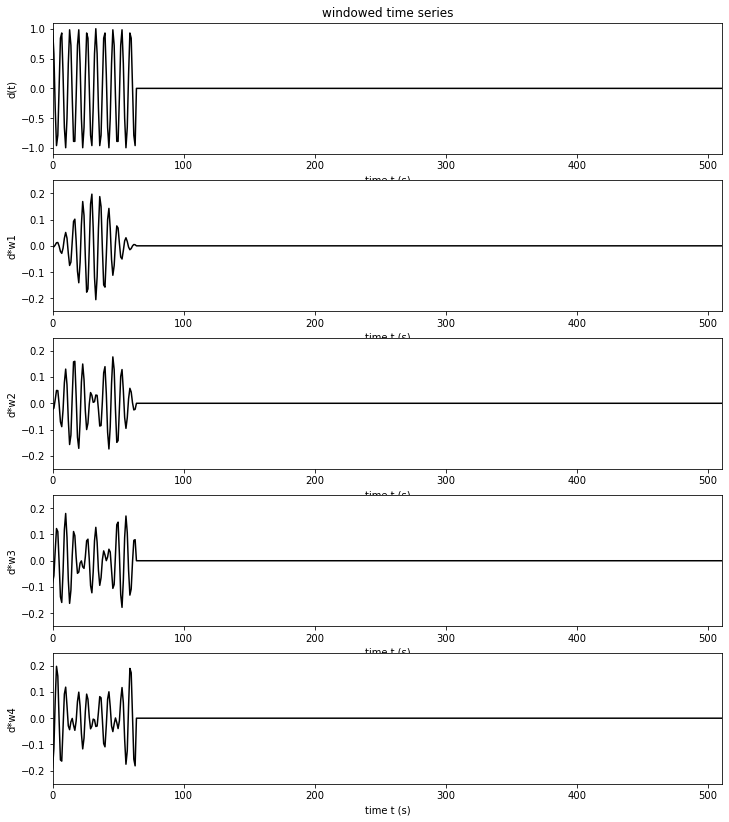

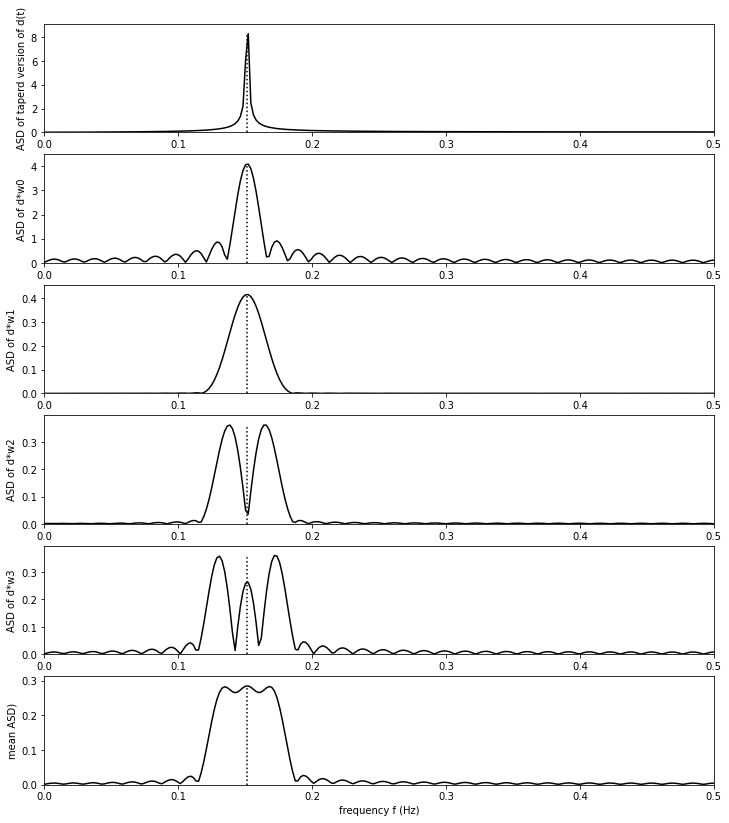

In [24]:
# eda09_21
# MultiTaper analysis

# standard time/frequency set up
N=64;
Dt=1;
t = np.zeros((N,1));
t[:,0] = Dt*np.linspace(0,N-1,N);
tmin = t[0,0];
tmax=t[N-1,0];
fmax=1/(2.0*Dt);
No2 = floor(N/2);
Df=fmax/No2;
Nf=No2+1;
f=np.zeros((N,1));
f[:,0] = Df * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Dw=2*pi*Df;
w=np.zeros((N,1));
w[:,0] = Dw * np.concatenate( ( np.linspace(0,No2,Nf), np.linspace(-No2+1,-1,No2-1) ), axis=0 );
Nw=Nf;
fpos=np.zeros((Nf,1));
fpos[:,0] = Df * np.linspace(0,No2,Nf);
wpos=np.zeros((Nf,1));
wpos[:,0] = Dw * np.linspace(0,No2,Nf);
 
# choose bandwidth to be +/-3 Dw
f0 = 2*Df;
w0 = 2*pi*f0;

# matrix, M, of sinc functions
M = np.zeros((N,N));
for m in range(N):
    for n in range(N):
        M[m,n] = 2*w0*np.sinc( w0*(m-n)*Dt / pi);

# solve algebric eigenvalue problem
# eig sorts in ascending order
[lam, V] = la.eigh(M);
print('6 largest eigenvalues:');
for m in range(N-5,N):
    print("    %d: %f" % (m, lam[m]) );

# four largest eigenvectors
w1 = np.zeros((N,1));
w2 = np.zeros((N,1));
w3 = np.zeros((N,1));
w4 = np.zeros((N,1));
w1[:,0] = np.copy( V[:,N-1] );
w2[:,0] = np.copy( V[:,N-2] );
w3[:,0] = np.copy( V[:,N-3] );
w4[:,0] = np.copy( V[:,N-4] );

# power spectral density of window functions
s1 = np.zeros((Nf,1));
s2 = np.zeros((Nf,1));
s3 = np.zeros((Nf,1));
s4 = np.zeros((Nf,1));
norm = (Dt**2)/tmax;
temp1 = norm * np.power(np.abs(np.fft.fft(w1,axis=0)),2);
temp2 = norm * np.power(np.abs(np.fft.fft(w2,axis=0)),2);
temp3 = norm * np.power(np.abs(np.fft.fft(w3,axis=0)),2);
temp4 = norm * np.power(np.abs(np.fft.fft(w4,axis=0)),2);
s1[:,0] = temp1[0:Nf,0];
s2[:,0] = temp2[0:Nf,0];
s3[:,0] = temp3[0:Nf,0];
s4[:,0] = temp4[0:Nf,0];

# time domain plot
fig1 = plt.figure(1,figsize=(12,14));
winmin = -0.25;
winmax = -winmin;

ax1 = plt.subplot(4,1,1);
plt.axis( [0, tmax, winmin, winmax] );
plt.plot(t, w1, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('w1(t)');
plt.title('tapers');

ax2 = plt.subplot(4,1,2);
plt.axis( [0, tmax, winmin, winmax] );
plt.plot(t, w2, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('w1(t)');

ax3 = plt.subplot(4,1,3);
plt.axis( [0, tmax, winmin, winmax] );
plt.plot(t, w3, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('w1(t)');

ax4 = plt.subplot(4,1,4);
plt.axis( [0, tmax, winmin, winmax] );
plt.plot(t, w4, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('w1(t)');

plt.show();

# plot amplitude spectral density of window functions
fig2 = plt.figure(2,figsize=(12,14));

ax1 = plt.subplot(4,1,1);
plt.axis( [0, fmax, 0, 1.1*np.max(np.sqrt(s1))] );
plt.plot(fpos,s1, 'k-' );
plt.plot( [f0, f0], [0, np.max(np.sqrt(s1))], 'k:' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('w1(f)');
plt.title('ASD of tapers');

ax2 = plt.subplot(4,1,2);
plt.axis( [0, fmax, 0, 1.1*np.max(np.sqrt(s2))] );
plt.plot(fpos,s2, 'k-' );
plt.plot( [f0, f0], [0, np.max(np.sqrt(s3))], 'k:' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('w1(f)');

ax3 = plt.subplot(4,1,3);
plt.axis( [0, fmax, 0, 1.1*np.max(np.sqrt(s3))] );
plt.plot(fpos,s3, 'k-' );
plt.plot( [f0, f0], [0, np.max(np.sqrt(s3))], 'k:' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('w1(f)');

ax4 = plt.subplot(4,1,4);
plt.axis( [0, fmax, 0, 1.1*np.max(np.sqrt(s4))] );
plt.plot(fpos,s4, 'k-' );
plt.plot( [f0, f0], [0, np.max(np.sqrt(s4))], 'k:' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('w1(f)');

plt.show();

# new, longer time interval, with same sampling interval
N2=512;
Dt2 = 1.0;
N2o2 = floor(N2/2);
Nf2=N2o2+1;
t2 = np.zeros((N2,1));
t2[:,0] = Dt*np.linspace(0,N2-1,N2);
tmin2 = t2[0,0];
tmax2 = t2[N2-1,0];
fmax2=1/(2.0*Dt2);
Df2=fmax2/N2o2;
Nf2=N2o2+1;
f2=np.zeros((N2,1));
f2[:,0] = Df2 * np.concatenate( ( np.linspace(0,N2o2,Nf2), np.linspace(-N2o2+1,-1,N2o2-1) ), axis=0 );
Dw2=2*pi*Df2;
w_2=np.zeros((N2,1));
w_2[:,0] = Dw2 * np.concatenate( ( np.linspace(0,N2o2,Nf2), np.linspace(-N2o2+1,-1,N2o2-1) ), axis=0 );
Nw2=Nf2;
fpos2=np.zeros((Nf2,1));
fpos2[:,0] = Df2 * np.linspace(0,N2o2,Nf2);
wpos2=np.zeros((Nf2,1));
wpos2[:,0] = Dw2 * np.linspace(0,N2o2,Nf2);

# create time series and window it
ff= fmax/3.3;
ww= 2*pi*ff;
d=np.cos(ww*t2);
dw0 = np.zeros((N,1));
dw1 = np.zeros((N,1));
dw2 = np.zeros((N,1));
dw3 = np.zeros((N,1));
dw4 = np.zeros((N,1));

w0 = np.ones((N,1));
we = np.zeros((N2-N,1));

dw0 = np.multiply( np.concatenate( (w0,we), axis=0 ), d );
dw1 = np.multiply( np.concatenate( (w1,we), axis=0 ), d );
dw2 = np.multiply( np.concatenate( (w2,we), axis=0 ), d );
dw3 = np.multiply( np.concatenate( (w3,we), axis=0 ), d );
dw4 = np.multiply( np.concatenate( (w4,we), axis=0 ), d );

# plot windowed time series
fig2 = plt.figure(2,figsize=(12,14));

ax1 = plt.subplot(5,1,1);
plt.axis( [tmin2, tmax2, -1.1, 1.1] );
plt.plot(t2, dw0, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('d(t)');
plt.title('windowed time series');

ax2 = plt.subplot(5,1,2);
plt.axis( [tmin2, tmax2, winmin, winmax] );
plt.plot(t2, dw1, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('d*w1')

ax3 = plt.subplot(5,1,3);
plt.axis( [tmin2, tmax2, winmin, winmax] );
plt.plot(t2, dw2, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('d*w2')

ax4 = plt.subplot(5,1,4);
plt.axis( [tmin2, tmax2, winmin, winmax] );
plt.plot(t2, dw3, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('d*w3')

ax5 = plt.subplot(5,1,5);
plt.axis( [tmin2, tmax2, winmin, winmax] );
plt.plot(t2, dw4, 'k-' );
plt.xlabel('time t (s)');                 
plt.ylabel('d*w4')

plt.show();

# power spectral density of time series
norm = (Dt2**2)/tmax2;
temp = norm * np.power( np.abs(np.fft.fft(d,axis=0)),2);
ds = np.zeros((Nf2,1));
ds[:,0] = temp[0:Nf2,0];

norm = (Dt2**2)/tmax;
temp0 = norm * np.power( np.abs(np.fft.fft(dw0,axis=0)),2);
temp1 = norm * np.power( np.abs(np.fft.fft(dw1,axis=0)),2);
temp2 = norm * np.power( np.abs(np.fft.fft(dw2,axis=0)),2);
temp3 = norm * np.power( np.abs(np.fft.fft(dw3,axis=0)),2);
temp4 = norm * np.power( np.abs(np.fft.fft(dw4,axis=0)),2);
dw0s = np.zeros((Nf2,1));
dw1s = np.zeros((Nf2,1));
dw2s = np.zeros((Nf2,1));
dw3s = np.zeros((Nf2,1));
dw4s = np.zeros((Nf2,1));
dw0s[:,0] = temp0[0:Nf2,0];
dw1s[:,0] = temp1[0:Nf2,0];
dw2s[:,0] = temp2[0:Nf2,0];
dw3s[:,0] = temp3[0:Nf2,0];
dw4s[:,0] = temp4[0:Nf2,0];

# average power spectral densities
dws = (1/3)*( dw1s + dw2s + dw3s  );

# plot amplitude spectral density of window functions
fig4 = plt.figure(2,figsize=(12,14));

ax1 = plt.subplot(6,1,1);
plt.axis( [0, fmax2, 0, 1.1*np.max(np.sqrt(ds))] );
plt.plot(fpos2,np.sqrt(ds), 'k-' );
plt.plot( [ff, ff], [0, np.max(np.sqrt(ds))], 'k:' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('ASD of d');
plt.ylabel('ASD of taperd version of d(t)');

ax2 = plt.subplot(6,1,2);
plt.axis( [0, fmax2, 0, 1.1*np.max(np.sqrt(dw0s))] );
plt.plot(fpos2,np.sqrt(dw0s), 'k-' );
plt.plot( [ff, ff], [0, np.max(np.sqrt(dw0s))], 'k:' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('ASD of d*w0');

ax3 = plt.subplot(6,1,3);
plt.axis( [0, fmax2, 0, 1.1*np.max(np.sqrt(dw1s))] );
plt.plot(fpos2,np.sqrt(dw1s), 'k-' );
plt.plot( [ff, ff], [0, np.max(np.sqrt(dw1s))], 'k:' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('ASD of d*w1');

ax4 = plt.subplot(6,1,4);
plt.axis( [0, fmax2, 0, 1.1*np.max(np.sqrt(dw2s))] );
plt.plot(fpos2,np.sqrt(dw2s), 'k-' );
plt.plot( [ff, ff], [0, np.max(np.sqrt(dw2s))], 'k:' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('ASD of d*w2');

ax5 = plt.subplot(6,1,5);
plt.axis( [0, fmax2, 0, 1.1*np.max(np.sqrt(dw3s))] );
plt.plot(fpos2,np.sqrt(dw3s), 'k-' );
plt.plot( [ff, ff], [0, np.max(np.sqrt(dw3s))], 'k:' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('ASD of d*w3');

ax6 = plt.subplot(6,1,6);
plt.axis( [0, fmax2, 0, 1.1*np.max(np.sqrt(dws))] );
plt.plot(fpos2,np.sqrt(dws), 'k-' );
plt.plot( [ff, ff], [0, np.max(np.sqrt(dws))], 'k:' );
plt.xlabel('frequency f (Hz)');                 
plt.ylabel('mean ASD)');

plt.show();
